# The Rules Behind Housing Prices in the Neighborhoods of Munich City



## - An applied data science project with machining learning by Nan Chen

*Description:* this project demo shows how to apply simple approaches in data science to obtain insights into some data as common as the housing prices in Munich. The methods adopted by the project include python libraries numpy, pandas and lxml to extract and process data from online source, and geopy to transfer address into geographical coordinates. The data visualization part is performed by matplotlib for plotting charts, seaborn to reveal variable correlations, as well as drawing maps by folium plus detailed features by requests and json. As next step, the location provider Foursquare is used to search for the nearby venues. After making a better generalization based on the original venue categories provided by Foursquare API, they can be processed by KMeans for neighborhood clustering. In this way, all neighborhoods are clustered by the machine by their shared interesting characters. As the final step, the counting numbers of venue categories are fed into sklearn to formulate an insightful price model. The entire data set is divided into a train group for developing model and a test group for checking result. Different models (Simple Linear Regression vs. Multiple Linear Regression vs. Multiple-variable Polynomial Fit) are attempted to select the best. Finally, the new price models can be proved by feeding it with some new data, in which the estimated prices are found to be meaningful with tolerable errors compared to the reality.

# Notebook Preparation

In [2]:
!conda install -c conda-forge geopy --ye

Solving environment: ...working... done

# All requested packages already installed.



In [3]:
# To handle german characters
#!/usr/bin/env python
# -*- coding: iso-8859-1 -*-
import sys
# Encoding der Standardausgabe herausfinden
stdout_encoding = sys.stdout.encoding or sys.getfilesystemencoding()
# Nachricht definieren (durch das Encoding Cookie als iso-8859-1 gekennzeichnet)
#message = "Hallo Österreich"
#print(message)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
%matplotlib inline
import json
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import folium
print('Libraries imported.')

Libraries imported.


In [5]:
from geopy.geocoders import Nominatim 
print("geopy installed")

geopy installed


In [6]:
conda install -c anaconda lxml

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - lxml


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                 pkgs/main --> anaconda
  lxml                                            pkgs/main --> anaconda
  openssl                                         pkgs/main --> anaconda


Preparing transaction: ...working... done
Verifying transaction: ...working... failed

Note: you may need to restart the kernel to use updated packages.



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




# 1. Introduction - get the table of neighborhood from online source

In [369]:
source = "https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens"

# Data wrangling
columns_filtered = ["Stadtbezirk", "Fläche(km²)", "Einwohner"]
df_unfiltered = pd.read_html(source)[0]
df = df_unfiltered.loc[:, columns_filtered]
df.rename(columns={"Stadtbezirk": "Neighborhood", "Fläche(km²)": "Area in km2", "Einwohner": "Population"}, inplace=True)
df.drop(df.tail(1).index, inplace = True)

df = df.astype({'Population': 'float32'})
df['Area in km2'] *=0.01
df['Population'] *=1000
df = df.astype({'Population': 'int32'})
df

Neighborhood  Area in km2  Population
0                                      Altstadt-Lehel         3.15       21126
1                        Ludwigsvorstadt-Isarvorstadt         4.40       51933
2                                         Maxvorstadt         4.30       51834
3                                      Schwabing-West         4.36       68935
4                                       Au-Haidhausen         4.22       61654
5                                            Sendling         3.94       41256
6                                   Sendling-Westpark         7.81       60498
7                                    Schwanthalerhöhe         2.07       29611
8                               Neuhausen-Nymphenburg        12.91      100213
9                                             Moosach        11.09       54872
10                              Milbertshofen-Am Hart        13.42       76559
11                                 Schwabing-Freimann        25.67       78657
12                                        Bogenhausen        23.71       90025
13                                       Berg am Laim         6.31       47000
14                                     Trudering-Riem        22.45       73479
15                                 Ramersdorf-Perlach        19.90      117918
16                            Obergiesing-Fasangarten         5.72       54498
17                            Untergiesing-Harlaching         8.06       53243
18  Thalkirchen-Obersendling-Forstenried-Fürstenri...        17.76       97689
19                                             Hadern         9.22       50165
20                                 Pasing-Obermenzing        16.50       76348
21                         Aubing-Lochhausen-Langwied        34.06       49072
22                                Allach-Untermenzing        15.45       34277
23                             Feldmoching-Hasenbergl        28.94       62069
24                                               Laim         5.29       57111

In [370]:
df.shape

(25, 3)

In [371]:
df.median()

Area in km2        9.22
Population     57111.00
dtype: float64

The median area of neighborhood (9.2km²) affects the searching radius ($A=\pi r²$), so the radius used later for the searching request will be around 1700m

In [372]:
df['Population Density'] = df['Population']/df['Area in km2']
df_sorted = df.sort_values(by=['Population Density'], ascending=False)
df_sorted

Neighborhood  Area in km2  \
3                                      Schwabing-West         4.36   
4                                       Au-Haidhausen         4.22   
7                                    Schwanthalerhöhe         2.07   
2                                         Maxvorstadt         4.30   
1                        Ludwigsvorstadt-Isarvorstadt         4.40   
24                                               Laim         5.29   
5                                            Sendling         3.94   
16                            Obergiesing-Fasangarten         5.72   
8                               Neuhausen-Nymphenburg        12.91   
6                                   Sendling-Westpark         7.81   
13                                       Berg am Laim         6.31   
0                                      Altstadt-Lehel         3.15   
17                            Untergiesing-Harlaching         8.06   
15                                 Ramersdorf-Perlach        19.90   
10                              Milbertshofen-Am Hart        13.42   
18  Thalkirchen-Obersendling-Forstenried-Fürstenri...        17.76   
19                                             Hadern         9.22   
9                                             Moosach        11.09   
20                                 Pasing-Obermenzing        16.50   
12                                        Bogenhausen        23.71   
14                                     Trudering-Riem        22.45   
11                                 Schwabing-Freimann        25.67   
22                                Allach-Untermenzing        15.45   
23                             Feldmoching-Hasenbergl        28.94   
21                         Aubing-Lochhausen-Langwied        34.06   

    Population  Population Density  
3        68935        15810.779817  
4        61654        14609.952607  
7        29611        14304.830918  
2        51834        12054.418605  
1        51933        11802.954545  
24       57111        10796.030246  
5        41256        10471.065990  
16       54498         9527.622378  
8       100213         7762.432223  
6        60498         7746.222791  
13       47000         7448.494453  
0        21126         6706.666667  
17       53243         6605.831266  
15      117918         5925.527638  
10       76559         5704.843517  
18       97689         5500.506757  
19       50165         5440.889371  
9        54872         4947.880974  
20       76348         4627.151515  
12       90025         3796.921130  
14       73479         3273.006682  
11       78657         3064.160499  
22       34277         2218.576052  
23       62069         2144.747754  
21       49072         1440.751615

In [373]:
df_density = pd.DataFrame(data=df_sorted, columns=['Population Density'])
df_density = df_density.reset_index(drop=True)
df_density.shape

(25, 1)

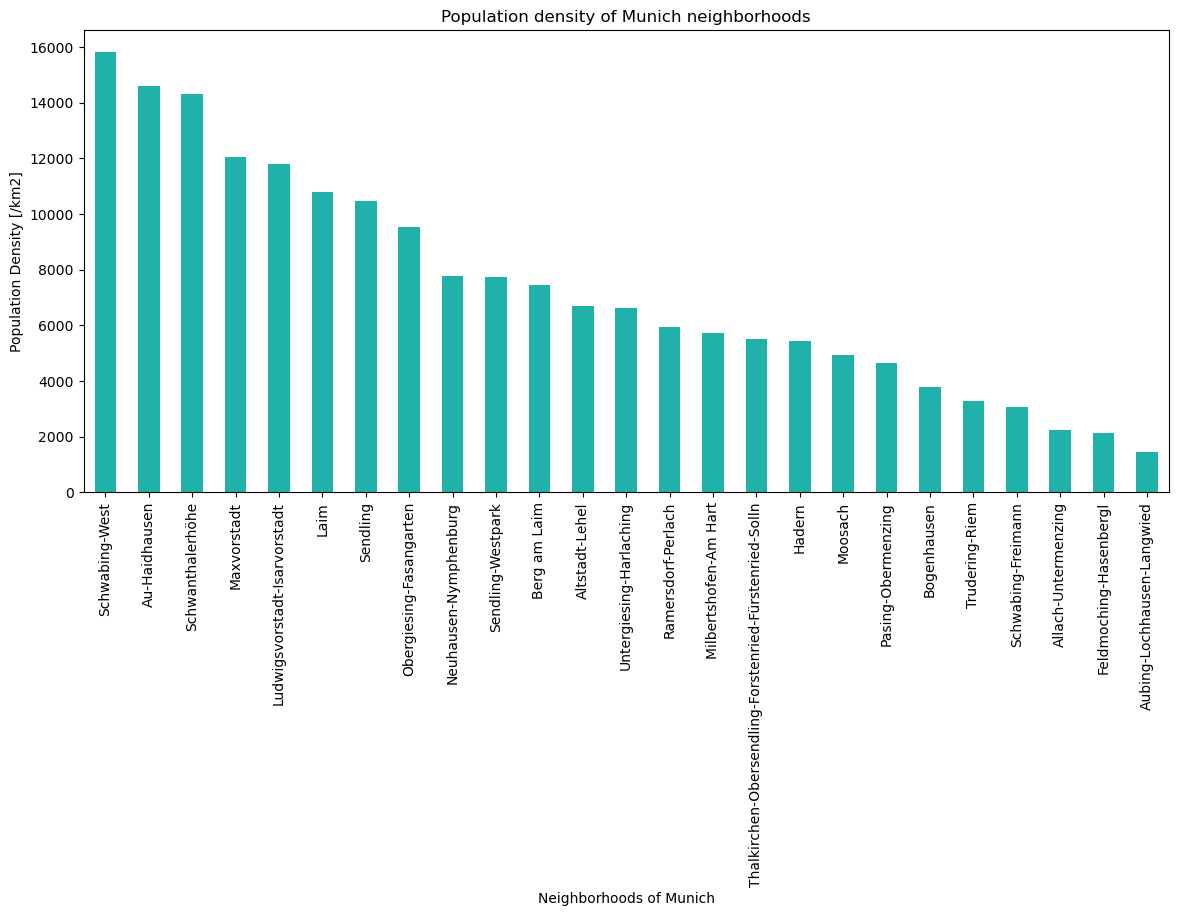

In [374]:
# Line plot to show population density of neighborhoods
N = df_density.shape[0]
df_density.plot(kind='bar', 
                figsize=(14, 6),
                color = 'lightseagreen',
                legend=None)
plt.xticks(np.arange(N), df_sorted.Neighborhood, rotation=90)
plt.title('Population density of Munich neighborhoods')
plt.xlabel('Neighborhoods of Munich')
plt.ylabel('Population Density [/km2]')
plt.show()

In [375]:
url = "https://suedbayerische-immobilien.de/Immobilienpreise-Muenchen"

# Data wrangling
df_price_original = pd.read_html(url)[0]
columns_translate = {"Stadtteile Münchens":"Neighborhood", "Preise in Euro/m²": "Price in Euro/qm"}
df_price_original.rename(columns=columns_translate, inplace=True)
df_price_original['Price in Euro/qm'] *=0.01
df_price_original['Neighborhood'] = df_price_original['Neighborhood'].str.replace(' – ','-')
df_price_original['Neighborhood'] = df_price_original['Neighborhood'].str.replace('–','-')
df_price_original

Neighborhood  Price in Euro/qm
0                                      Altstadt-Lehel           9208.19
1                     Maxvorstadt-Universitätsviertel           8952.17
2                                           Schwabing           8673.53
3                        Ludwigsvorstadt-Isarvorstadt           8464.50
4                           Altbogenhausen-Herzogpark           8399.89
5                                         Nymphenburg           8394.83
6                                         Maxvorstadt           7968.36
7                                       Au-Haidhausen           7872.34
8                                          Harlaching           7837.55
9                                      Schwabing-West           7628.31
10                                          Neuhausen           7419.76
11                                   Schwanthalerhöhe           6964.68
12                          Oberföhring-Englschalking           6548.61
13                                           Sendling           6426.75
14                                Alte Heide-Hirschau           6304.83
15                                       Untergiesing           6095.91
16                                 Pasing-Obermenzing           6061.30
17                                  Sendling-Westpark           6008.75
18                                             Hadern           5991.38
19                                       Berg am Laim           5921.69
20                                      Milbertshofen           5886.83
21  Thalkirchen-Obersendling-Forstenried-Fürstenri...           5852.46
22                                Allach-Untermenzing           5699.77
23                                            Moosach           5643.69
24                                 Ramersdorf-Perlach           5590.75
25                                     Trudering-Riem           5549.67
26                           Johanneskirchen-Daglfing           5538.43
27                                               Laim           5489.51
28                         Aubing-Lochhausen-Langwied           5396.16
29                                        Obergiesing           5364.33
30                                           Freimann           5137.91
31                                            Am Hart           4876.66
32                             Feldmoching-Hasenbergl           4824.41

In [376]:
dict_translate = {'Maxvorstadt-Universitätsviertel':'Maxvorstadt', 
                  'Schwabing':'Schwabing-Freimann',
                  'Altbogenhausen-Herzogpark':'Bogenhausen',
                  'Nymphenburg':'Neuhausen-Nymphenburg',
                  'Harlaching': 'Untergiesing-Harlaching',
                  'Neuhausen':'Neuhausen-Nymphenburg',
                  'Untergiesing': 'Untergiesing-Harlaching',
                  'Milbertshofen':'Milbertshofen-Am Hart',
                  'Obergiesing':'Obergiesing-Fasangarten',
                  'Freimann':'Schwabing-Freimann',
                  'Am Hart':'Milbertshofen-Am Hart'}

In [377]:
df_price = df_price_original.copy(deep=True)
df_price.drop([12,14,26], inplace=True)
df_price = df_price.replace({'Neighborhood' : dict_translate})
#df_price = df_price.reset_index(drop=True)


df_price = df_price.groupby('Neighborhood').mean().reset_index() # group neighborhoods together and get averaged price
df_price = df_price.sort_values(by=['Price in Euro/qm'], ascending=False)
df_price = df_price.reset_index(drop=True)
df_price

Neighborhood  Price in Euro/qm
0                                      Altstadt-Lehel          9208.190
1                        Ludwigsvorstadt-Isarvorstadt          8464.500
2                                         Maxvorstadt          8460.265
3                                         Bogenhausen          8399.890
4                               Neuhausen-Nymphenburg          7907.295
5                                       Au-Haidhausen          7872.340
6                                      Schwabing-West          7628.310
7                             Untergiesing-Harlaching          6966.730
8                                    Schwanthalerhöhe          6964.680
9                                  Schwabing-Freimann          6905.720
10                                           Sendling          6426.750
11                                 Pasing-Obermenzing          6061.300
12                                  Sendling-Westpark          6008.750
13                                             Hadern          5991.380
14                                       Berg am Laim          5921.690
15  Thalkirchen-Obersendling-Forstenried-Fürstenri...          5852.460
16                                Allach-Untermenzing          5699.770
17                                            Moosach          5643.690
18                                 Ramersdorf-Perlach          5590.750
19                                     Trudering-Riem          5549.670
20                                               Laim          5489.510
21                         Aubing-Lochhausen-Langwied          5396.160
22                              Milbertshofen-Am Hart          5381.745
23                            Obergiesing-Fasangarten          5364.330
24                             Feldmoching-Hasenbergl          4824.410

In [378]:
#df_sorted = df_sorted.groupby('Neighborhood').mean().reset_index()
#df_sorted

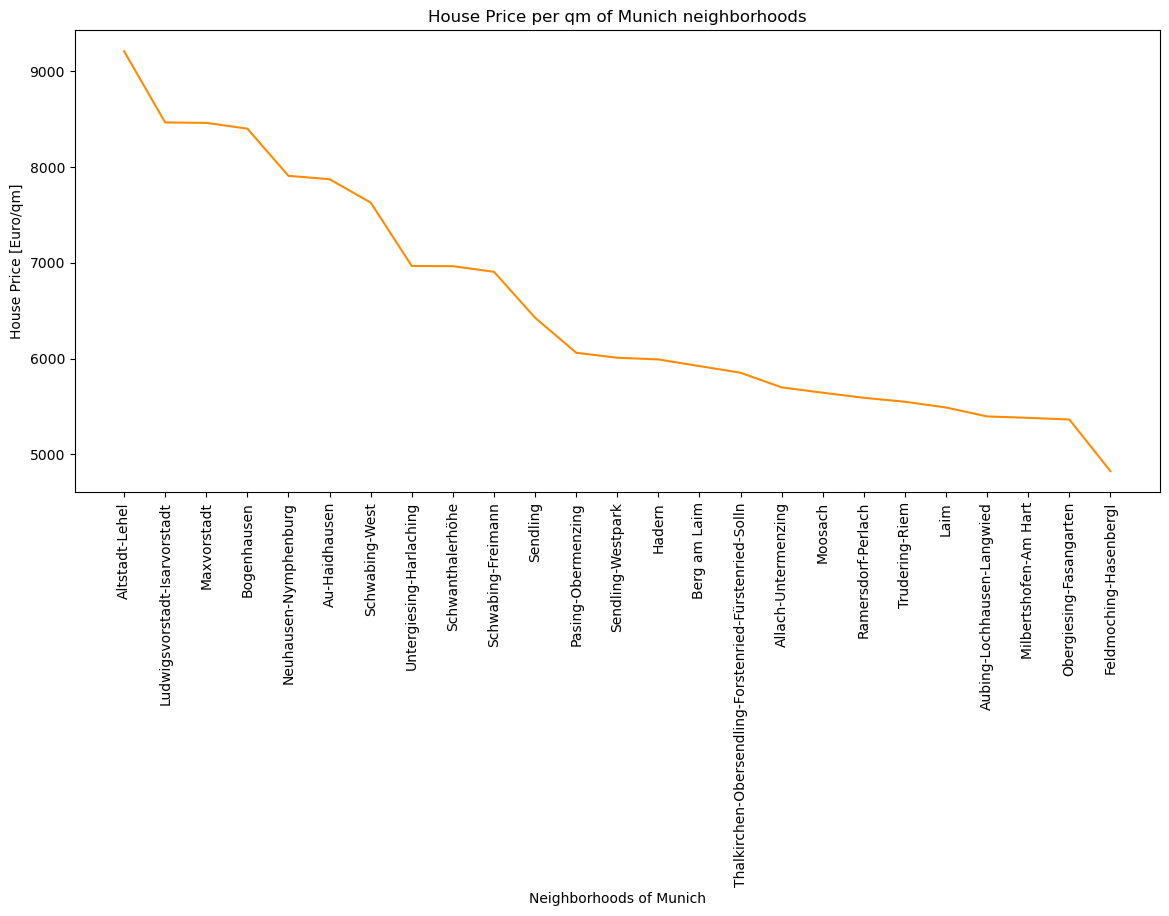

In [379]:
# Line plot to show house prices of neighborhoods

I = df_price.shape[0]
df_price.plot(kind='line', 
                figsize=(14, 6),
                color = 'darkorange',
                legend=None)
plt.xticks(np.arange(N), df_price.Neighborhood, rotation=90)
plt.title('House Price per qm of Munich neighborhoods')
plt.xlabel('Neighborhoods of Munich')
plt.ylabel('House Price [Euro/qm]')
plt.show()

In [380]:
#df_sorted
#df_price
df_city = pd.DataFrame.empty
df_city = pd.merge(df_price, df_sorted, on="Neighborhood")
df_city = df_city.sort_values(by=['Population Density'], ascending=False)
df_city = df_city.reset_index(drop=True)
df_city

Neighborhood  Price in Euro/qm  \
0                                      Schwabing-West          7628.310   
1                                       Au-Haidhausen          7872.340   
2                                    Schwanthalerhöhe          6964.680   
3                                         Maxvorstadt          8460.265   
4                        Ludwigsvorstadt-Isarvorstadt          8464.500   
5                                                Laim          5489.510   
6                                            Sendling          6426.750   
7                             Obergiesing-Fasangarten          5364.330   
8                               Neuhausen-Nymphenburg          7907.295   
9                                   Sendling-Westpark          6008.750   
10                                       Berg am Laim          5921.690   
11                                     Altstadt-Lehel          9208.190   
12                            Untergiesing-Harlaching          6966.730   
13                                 Ramersdorf-Perlach          5590.750   
14                              Milbertshofen-Am Hart          5381.745   
15  Thalkirchen-Obersendling-Forstenried-Fürstenri...          5852.460   
16                                             Hadern          5991.380   
17                                            Moosach          5643.690   
18                                 Pasing-Obermenzing          6061.300   
19                                        Bogenhausen          8399.890   
20                                     Trudering-Riem          5549.670   
21                                 Schwabing-Freimann          6905.720   
22                                Allach-Untermenzing          5699.770   
23                             Feldmoching-Hasenbergl          4824.410   
24                         Aubing-Lochhausen-Langwied          5396.160   

    Area in km2  Population  Population Density  
0          4.36       68935        15810.779817  
1          4.22       61654        14609.952607  
2          2.07       29611        14304.830918  
3          4.30       51834        12054.418605  
4          4.40       51933        11802.954545  
5          5.29       57111        10796.030246  
6          3.94       41256        10471.065990  
7          5.72       54498         9527.622378  
8         12.91      100213         7762.432223  
9          7.81       60498         7746.222791  
10         6.31       47000         7448.494453  
11         3.15       21126         6706.666667  
12         8.06       53243         6605.831266  
13        19.90      117918         5925.527638  
14        13.42       76559         5704.843517  
15        17.76       97689         5500.506757  
16         9.22       50165         5440.889371  
17        11.09       54872         4947.880974  
18        16.50       76348         4627.151515  
19        23.71       90025         3796.921130  
20        22.45       73479         3273.006682  
21        25.67       78657         3064.160499  
22        15.45       34277         2218.576052  
23        28.94       62069         2144.747754  
24        34.06       49072         1440.751615

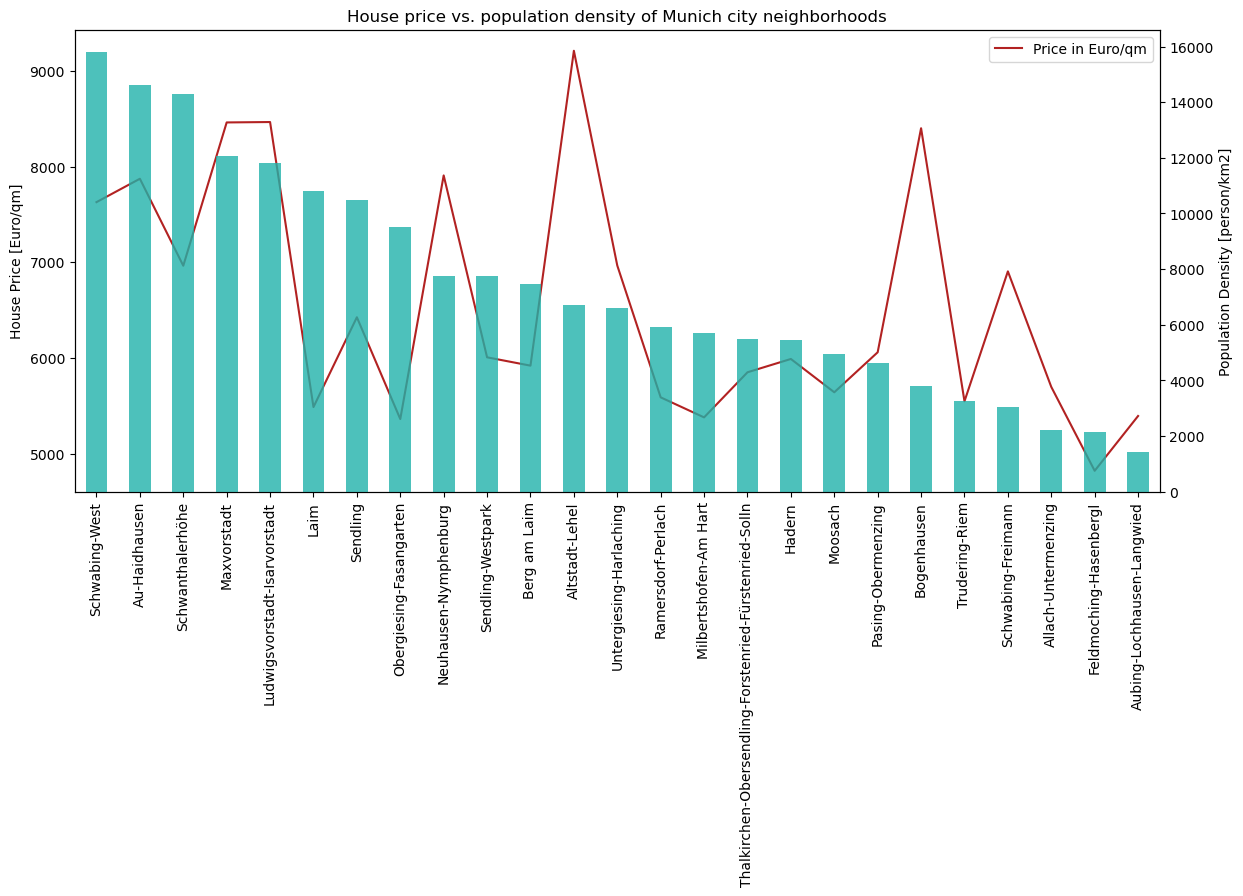

In [381]:
# plot line and bar plots together

df_city['Price in Euro/qm'].plot(kind='line', 
                figsize=(14, 6),
                color = 'firebrick')
plt.ylabel('House Price [Euro/qm]')
plt.legend()

df_city['Population Density'].plot(kind='bar',
                width=0.50,
                alpha=0.80,
                color='lightseagreen',
                secondary_y=True)
plt.ylabel('Population Density [person/km2]')

plt.xticks(np.arange(N), df_city.Neighborhood, rotation=90)
plt.title('House price vs. population density of Munich city neighborhoods')
plt.show()

# 2. A first glance of data by `seaborn` 

In [382]:
df_city.corr()

Price in Euro/qm  Area in km2  Population  \
Price in Euro/qm            1.000000    -0.407529   -0.124438   
Area in km2                -0.407529     1.000000    0.457620   
Population                 -0.124438     0.457620    1.000000   
Population Density          0.462490    -0.811897   -0.215528   

                    Population Density  
Price in Euro/qm              0.462490  
Area in km2                  -0.811897  
Population                   -0.215528  
Population Density            1.000000

(4000.0, 9427.379)

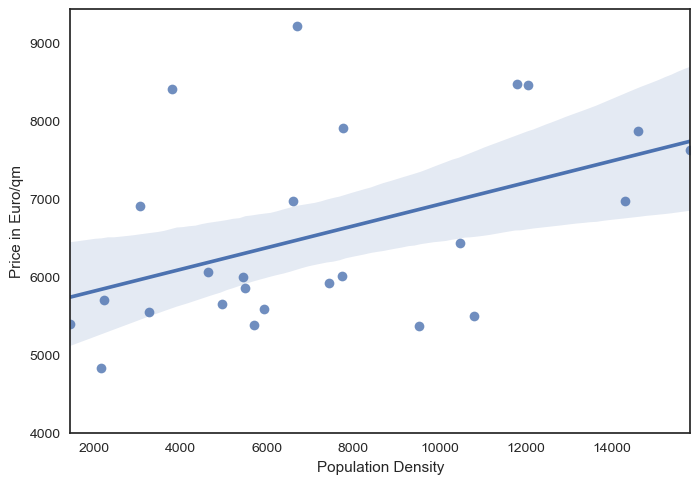

In [383]:
import seaborn as sns
mpl.style.use('seaborn')
mpl.style.use('seaborn-white')
#mpl.style.use('classic')

sns.regplot(x="Population Density", y="Price in Euro/qm", data=df_city)
plt.ylim(4000,)

In [384]:
df_city[["Population Density", "Price in Euro/qm"]].corr()

Population Density  Price in Euro/qm
Population Density             1.00000           0.46249
Price in Euro/qm               0.46249           1.00000

(4000.0, 9470.198875852991)

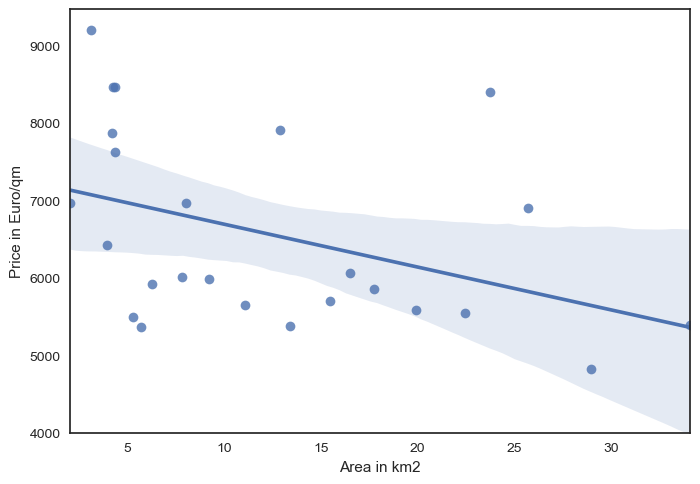

In [385]:
sns.regplot(x="Area in km2", y="Price in Euro/qm", data=df_city)
plt.ylim(4000,)

In [386]:
df_city[["Area in km2", "Price in Euro/qm"]].corr()

Area in km2  Price in Euro/qm
Area in km2          1.000000         -0.407529
Price in Euro/qm    -0.407529          1.000000

(4000.0, 9432.692717871085)

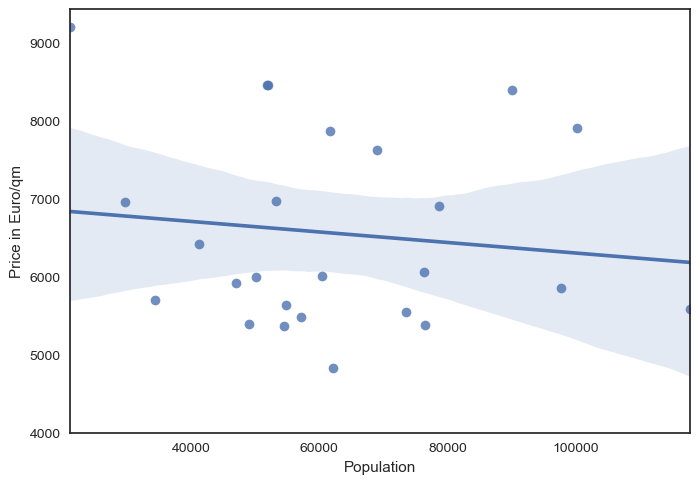

In [387]:
sns.regplot(x="Population", y="Price in Euro/qm", data=df_city)
plt.ylim(4000,)

In [388]:
df_city[["Population", "Price in Euro/qm"]].corr()

Population  Price in Euro/qm
Population          1.000000         -0.124438
Price in Euro/qm   -0.124438          1.000000

# 3. Neighborhoods on the map by `Folium`

In [389]:
# Get the center location of Munich city

geolocator = Nominatim(user_agent="munich_agent")
location = geolocator.geocode("Munich")
lat_munich = location.latitude
lon_munich = location.longitude
print('The geographical coordinate of Munich City are {}, {}.'.format(lat_munich, lon_munich))

The geographical coordinate of Munich City are 48.1371079, 11.5753822.


In [390]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_bezirk = pd.DataFrame(columns=column_names)
df_bezirk = df_bezirk.astype({'Latitude': 'float32', 'Longitude': 'float32'})
df_bezirk

Empty DataFrame
Columns: [Neighborhood, Latitude, Longitude]
Index: []

In [391]:
for i in range(df_city.shape[0]):
    Bezirk = df_city.loc[i, 'Neighborhood']
    address = "{}, Munich".format(Bezirk)
    
    geolocator = Nominatim(user_agent="munich_agent")
    location = geolocator.geocode(address)
    df_bezirk.at[i, 'Neighborhood'] = Bezirk
    df_bezirk.at[i, 'Latitude'] = location.latitude
    df_bezirk.at[i, 'Longitude'] = location.longitude


In [392]:
df_result = pd.merge(df_city, df_bezirk, on="Neighborhood")
df_result

Neighborhood  Price in Euro/qm  \
0                                      Schwabing-West          7628.310   
1                                       Au-Haidhausen          7872.340   
2                                    Schwanthalerhöhe          6964.680   
3                                         Maxvorstadt          8460.265   
4                        Ludwigsvorstadt-Isarvorstadt          8464.500   
5                                                Laim          5489.510   
6                                            Sendling          6426.750   
7                             Obergiesing-Fasangarten          5364.330   
8                               Neuhausen-Nymphenburg          7907.295   
9                                   Sendling-Westpark          6008.750   
10                                       Berg am Laim          5921.690   
11                                     Altstadt-Lehel          9208.190   
12                            Untergiesing-Harlaching          6966.730   
13                                 Ramersdorf-Perlach          5590.750   
14                              Milbertshofen-Am Hart          5381.745   
15  Thalkirchen-Obersendling-Forstenried-Fürstenri...          5852.460   
16                                             Hadern          5991.380   
17                                            Moosach          5643.690   
18                                 Pasing-Obermenzing          6061.300   
19                                        Bogenhausen          8399.890   
20                                     Trudering-Riem          5549.670   
21                                 Schwabing-Freimann          6905.720   
22                                Allach-Untermenzing          5699.770   
23                             Feldmoching-Hasenbergl          4824.410   
24                         Aubing-Lochhausen-Langwied          5396.160   

    Area in km2  Population  Population Density   Latitude  Longitude  
0          4.36       68935        15810.779817  48.168270  11.569873  
1          4.22       61654        14609.952607  48.128754  11.590536  
2          2.07       29611        14304.830918  48.133781  11.541057  
3          4.30       51834        12054.418605  48.151093  11.562418  
4          4.40       51933        11802.954545  48.130341  11.573366  
5          5.29       57111        10796.030246  48.139549  11.502166  
6          3.94       41256        10471.065990  48.118011  11.539083  
7          5.72       54498         9527.622378  48.111156  11.588909  
8         12.91      100213         7762.432223  48.154221  11.531517  
9          7.81       60498         7746.222791  48.118031  11.519333  
10         6.31       47000         7448.494453  48.123482  11.633451  
11         3.15       21126         6706.666667  48.137829  11.574582  
12         8.06       53243         6605.831266  48.114964  11.570189  
13        19.90      117918         5925.527638  48.100895  11.633371  
14        13.42       76559         5704.843517  48.182384  11.575043  
15        17.76       97689         5500.506757  48.084213  11.508051  
16         9.22       50165         5440.889371  48.118065  11.481842  
17        11.09       54872         4947.880974  48.179893  11.510571  
18        16.50       76348         4627.151515  48.152363  11.468434  
19        23.71       90025         3796.921130  48.154781  11.633484  
20        22.45       73479         3273.006682  48.123177  11.664078  
21        25.67       78657         3064.160499  48.189278  11.608582  
22        15.45       34277         2218.576052  48.195156  11.462974  
23        28.94       62069         2144.747754  48.218460  11.520409  
24        34.06       49072         1440.751615  48.165058  11.400222

Create a default map of Munich City using `folium` with all the neighborhoods superimposed on top.

In [393]:
!wget --quiet = https://github.com/isellsoap/deutschlandGeoJSON/blob/master/3_regierungsbezirke/1_sehr_hoch.geo.json
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [394]:
geo_munich = r'1_sehr_hoch.geo.json'
map_munich = folium.Map(location=[lat_munich, lon_munich], width=970, height=750, zoom_start=12)
neighborhoods = df_result

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_munich)  
    
map_munich

# 4. Explore the venues of neighborhoods by `Foursquare`

In [395]:
CLIENT_ID = '14MSIOBKGTYU0DW2F0ACYYXMFPX3ZGD34DJME3RAZUBAWZL1' # your Foursquare ID
CLIENT_SECRET = 'I0RNVIJDEMMKJ1P0T1S3MAVWOSWUMM5AFPMXA0QPFUEAZJ4H' # your Foursquare Secret
ACCESS_TOKEN = 'D0S1I0XLO2TFKAZISMH45CWTEDBFQTFG14LKQYXDIEPBMBDZ' # your FourSquare Access Token
VERSION = '20210101'
LIMIT = 200
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 14MSIOBKGTYU0DW2F0ACYYXMFPX3ZGD34DJME3RAZUBAWZL1
CLIENT_SECRET:I0RNVIJDEMMKJ1P0T1S3MAVWOSWUMM5AFPMXA0QPFUEAZJ4H


In [396]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [397]:
def getNearbyVenues(names, latitudes, longitudes, radius=1700): # radius of finding venues set to 1700m
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'NeighborhoodLatitude', 
                  'NeighborhoodLongitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    
    return(nearby_venues)

In [398]:
munich_data = df_result
munich_venues = getNearbyVenues(names = munich_data['Neighborhood'],
                                latitudes = munich_data['Latitude'],
                                longitudes = munich_data['Longitude']
                                )

Schwabing-West
Au-Haidhausen
Schwanthalerhöhe
Maxvorstadt
Ludwigsvorstadt-Isarvorstadt
Laim
Sendling
Obergiesing-Fasangarten
Neuhausen-Nymphenburg
Sendling-Westpark
Berg am Laim
Altstadt-Lehel
Untergiesing-Harlaching
Ramersdorf-Perlach
Milbertshofen-Am Hart
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln
Hadern
Moosach
Pasing-Obermenzing
Bogenhausen
Trudering-Riem
Schwabing-Freimann
Allach-Untermenzing
Feldmoching-Hasenbergl
Aubing-Lochhausen-Langwied


In [399]:
print(munich_venues.shape)
pd.set_option('display.max_rows', 1000)
munich_venues

(1951, 7)


Neighborhood  NeighborhoodLatitude  NeighborhoodLongitude  \
0                 Schwabing-West             48.168270              11.569873   
1                 Schwabing-West             48.168270              11.569873   
2                 Schwabing-West             48.168270              11.569873   
3                 Schwabing-West             48.168270              11.569873   
4                 Schwabing-West             48.168270              11.569873   
...                          ...                   ...                    ...   
1946  Aubing-Lochhausen-Langwied             48.165058              11.400222   
1947  Aubing-Lochhausen-Langwied             48.165058              11.400222   
1948  Aubing-Lochhausen-Langwied             48.165058              11.400222   
1949  Aubing-Lochhausen-Langwied             48.165058              11.400222   
1950  Aubing-Lochhausen-Langwied             48.165058              11.400222   

                                Venue  VenueLatitude  VenueLongitude  \
0     Winterbiergarten Bamberger Haus      48.170647       11.568191   
1                        Luitpoldpark      48.172668       11.570256   
2                          Tante Emma      48.164408       11.574184   
3                            Georgios      48.165728       11.564714   
4                       Zum Ferdinand      48.170684       11.567918   
...                               ...            ...             ...   
1946                             Post      48.158648       11.415226   
1947               Apotheke am Weiher      48.176583       11.406941   
1948                     S Lochhausen      48.176292       11.408204   
1949             H Lochhausen Bahnhof      48.176858       11.407640   
1950                 H Neuaubing West      48.152557       11.410210   

            VenueCategory  
0               Gastropub  
1                    Park  
2                  Bistro  
3                 Taverna  
4     Austrian Restaurant  
...                   ...  
1946          Post Office  
1947             Pharmacy  
1948   Light Rail Station  
1949             Bus Stop  
1950             Bus Stop  

[1951 rows x 7 columns]

In [400]:
munich_venues.groupby('Neighborhood').count()
print('There are {} uniques categories within {} neighborhoods.'.format(len(munich_venues['VenueCategory'].unique()), len(munich_venues['Neighborhood'].unique())))

There are 228 uniques categories within 25 neighborhoods.


In [401]:
munich_venues['VenueCategory'].value_counts()

Café                                        115
Supermarket                                 111
German Restaurant                            97
Italian Restaurant                           96
Hotel                                        85
Drugstore                                    61
Bakery                                       60
Plaza                                        55
Greek Restaurant                             49
Ice Cream Shop                               45
Bus Stop                                     35
Park                                         35
Asian Restaurant                             34
Restaurant                                   31
Coffee Shop                                  31
Gym / Fitness Center                         28
Trattoria/Osteria                            27
Beer Garden                                  27
Bar                                          26
Vietnamese Restaurant                        25
Doner Restaurant                        

The "unique categories" seem to be too much detailed. I will try to group them into a fewer high-level categories

In [402]:
df = munich_venues.copy(deep=True)
df.shape

(1951, 7)

In [403]:
searchfor_restaurant = [' Restaurant', 'Breakfast', 'Steakhouse', 'Burger', 'Diner','Trattoria/Osteria', 'Taverna',
                        'Beer Garden', 'Brewery', 'BBQ', 'Manti Place', 'Fried Chicken']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_restaurant)), 'VenueCategory'] = 'Restaurant'

In [404]:
searchfor_coffee = ["Coffee","Café", 'Tea', "Ice Cream", 'Cafeteria']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_coffee)), 'VenueCategory'] = 'Cafe'


In [405]:
searchfor_bar = ["Pub","Bar","Club", 'Beer', 'Gastropub', 'Nightclub', 'Brewery', 'Cocktail', 'Speakeasy']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_bar)), 'VenueCategory'] = 'Nightpub'

In [406]:
searchfor_transport = [' Stop', ' Station']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_transport)), 'VenueCategory'] = 'PublicTranport'


In [407]:
searchfor_snack = ['Pizza','Burrito', 'Bistro', 'Cupcake', 'Sandwich', 'Soup', 'Salad', 'Food', 'Snack']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_snack)), 'VenueCategory'] = 'Snack'


In [408]:
searchfor_shop = ["Shop","Store","Boutique", "Grocery", 'shop', 'Retailer', 'Bodega', 'Butcher', 'Newsstand',
                  'Mall', 'Garden Center']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_shop)), 'VenueCategory'] = 'Shopping'


In [409]:
searchfor_sport = ['Sport', 'Fitness', 'Yoga', 'Gym', 'Pool', 'Soccer Field', 'Spa', 'Lounge', 'Stadium', 'Bowling', 'Hockey',
                   'Tennis','Skating','Escape Room']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_sport)), 'VenueCategory'] = 'SportFitness'


In [410]:
searchfor_supermarket = ["Market", "Supermarket"]
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_supermarket)), 'VenueCategory'] = 'Supermarket'


In [411]:
searchfor_hotel = ['Motel','Hotel', 'Hostel']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_hotel)), 'VenueCategory'] = 'Hotel'


In [412]:
searchfor_culture = ['Cultural Center', 'Opera', 'Theater', 'Museum', 'Bookstore', 
                     'Concert', 'Entertainment', 'Event', 'Music Venue', 'Community Center', 'Art']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_culture)), 'VenueCategory'] = 'Culture'


In [413]:
searchfor_park = ['Hill', 'Playground', 'Lake', 'Beach', ' Park', 'Sculpture', 'Garden', 'Fountain', 'Forest']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_park)), 'VenueCategory'] = 'Park'


In [414]:
searchfor_landmark = ['Plaza', 'Fountain', 'Roof Deck', 'Church', 'Historic', 'Landmark']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_landmark)), 'VenueCategory'] = 'Landmark'


In [415]:
searchfor_auto = ['Auto','Motor', 'Rental Car']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_auto)), 'VenueCategory'] = 'Autoservice'


In [416]:
searchfor_pharmacy = ['pharmacy','Drugstore']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_pharmacy)), 'VenueCategory'] = 'Pharmacy'


To simplify the case, let us omit all rest of venue categories with occurance frequency less than 5

In [417]:
df_refined = df[df.groupby('VenueCategory').VenueCategory.transform('count')>5].copy()
df_refined['VenueCategory'].value_counts()

Restaurant        642
Cafe              199
Shopping          159
Supermarket       126
SportFitness      116
Nightpub          112
Hotel              92
Snack              70
Culture            67
Landmark           67
Pharmacy           65
Park               64
PublicTranport     62
Bakery             60
Bank               16
Name: VenueCategory, dtype: int64

In [418]:
df_refined.head()

Neighborhood  NeighborhoodLatitude  NeighborhoodLongitude  \
0  Schwabing-West              48.16827              11.569873   
1  Schwabing-West              48.16827              11.569873   
2  Schwabing-West              48.16827              11.569873   
3  Schwabing-West              48.16827              11.569873   
4  Schwabing-West              48.16827              11.569873   

                             Venue  VenueLatitude  VenueLongitude  \
0  Winterbiergarten Bamberger Haus      48.170647       11.568191   
1                     Luitpoldpark      48.172668       11.570256   
2                       Tante Emma      48.164408       11.574184   
3                         Georgios      48.165728       11.564714   
4                    Zum Ferdinand      48.170684       11.567918   

  VenueCategory  
0      Nightpub  
1          Park  
2         Snack  
3    Restaurant  
4    Restaurant

In [419]:
#df_refined['VenueWithCategory'] = df.apply(lambda row: row.VenueCategory + ': ' + row.Venue, axis = 1)
#df_refined

In [420]:
# Plot venues on the map
!wget --quiet = https://github.com/isellsoap/deutschlandGeoJSON/blob/master/3_regierungsbezirke/1_sehr_hoch.geo.json
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [421]:
from folium import plugins

geo_munich = r'1_sehr_hoch.geo.json'
map_munich = folium.Map(location=[lat_munich, lon_munich], zoom_start=12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(map_munich)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label in zip(df_refined['VenueLatitude'], df_refined['VenueLongitude'], df_refined['VenueCategory']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label
    ).add_to(incidents)

# display map
map_munich

In [422]:
munich_venuesGrouped = df_refined.copy(deep=True)

# 5. Neighborhood Clustering by `KMeans`

In [423]:
munich_onehot = pd.get_dummies(munich_venuesGrouped[['VenueCategory']], prefix="", prefix_sep="")
munich_onehot['Neighborhood'] = munich_venuesGrouped['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [munich_onehot.columns[-1]] + list(munich_onehot.columns[:-1])
munich_onehot = munich_onehot[fixed_columns]

munich_onehot.shape

(1917, 16)

In [424]:
munich_grouped = munich_onehot.groupby('Neighborhood').mean().reset_index()
munich_grouped.head(25)

Neighborhood    Bakery      Bank  \
0                                 Allach-Untermenzing  0.083333  0.000000   
1                                      Altstadt-Lehel  0.000000  0.000000   
2                                       Au-Haidhausen  0.010204  0.000000   
3                          Aubing-Lochhausen-Langwied  0.100000  0.000000   
4                                        Berg am Laim  0.058824  0.014706   
5                                         Bogenhausen  0.025000  0.025000   
6                              Feldmoching-Hasenbergl  0.111111  0.000000   
7                                              Hadern  0.021739  0.065217   
8                                                Laim  0.062500  0.031250   
9                        Ludwigsvorstadt-Isarvorstadt  0.000000  0.000000   
10                                        Maxvorstadt  0.041237  0.000000   
11                              Milbertshofen-Am Hart  0.030303  0.010101   
12                                            Moosach  0.074627  0.000000   
13                              Neuhausen-Nymphenburg  0.040816  0.000000   
14                            Obergiesing-Fasangarten  0.020202  0.000000   
15                                 Pasing-Obermenzing  0.013333  0.000000   
16                                 Ramersdorf-Perlach  0.027778  0.000000   
17                                 Schwabing-Freimann  0.017857  0.017857   
18                                     Schwabing-West  0.030928  0.000000   
19                                   Schwanthalerhöhe  0.000000  0.000000   
20                                           Sendling  0.030000  0.000000   
21                                  Sendling-Westpark  0.042105  0.021053   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...  0.058824  0.044118   
23                                     Trudering-Riem  0.070175  0.000000   
24                            Untergiesing-Harlaching  0.010204  0.000000   

        Cafe   Culture     Hotel  Landmark  Nightpub      Park  Pharmacy  \
0   0.000000  0.000000  0.125000  0.000000  0.000000  0.083333  0.083333   
1   0.202020  0.050505  0.050505  0.131313  0.111111  0.030303  0.010101   
2   0.183673  0.081633  0.051020  0.071429  0.102041  0.030612  0.000000   
3   0.000000  0.000000  0.100000  0.000000  0.000000  0.000000  0.100000   
4   0.014706  0.000000  0.044118  0.000000  0.029412  0.014706  0.058824   
5   0.075000  0.012500  0.050000  0.037500  0.037500  0.087500  0.062500   
6   0.166667  0.000000  0.000000  0.055556  0.055556  0.055556  0.000000   
7   0.065217  0.000000  0.021739  0.043478  0.000000  0.000000  0.043478   
8   0.031250  0.031250  0.052083  0.031250  0.041667  0.010417  0.062500   
9   0.250000  0.070000  0.030000  0.070000  0.080000  0.040000  0.010000   
10  0.185567  0.051546  0.051546  0.082474  0.103093  0.041237  0.000000   
11  0.070707  0.030303  0.101010  0.010101  0.080808  0.030303  0.060606   
12  0.014925  0.014925  0.059701  0.014925  0.029851  0.000000  0.089552   
13  0.091837  0.030612  0.040816  0.051020  0.051020  0.020408  0.030612   
14  0.080808  0.010101  0.030303  0.050505  0.070707  0.020202  0.040404   
15  0.093333  0.026667  0.013333  0.013333  0.000000  0.026667  0.053333   
16  0.069444  0.013889  0.013889  0.013889  0.000000  0.041667  0.041667   
17  0.053571  0.035714  0.107143  0.000000  0.000000  0.035714  0.017857   
18  0.082474  0.061856  0.010309  0.030928  0.061856  0.051546  0.000000   
19  0.140000  0.050000  0.090000  0.010000  0.090000  0.020000  0.000000   
20  0.120000  0.050000  0.020000  0.000000  0.100000  0.030000  0.030000   
21  0.052632  0.063158  0.052632  0.031579  0.021053  0.084211  0.052632   
22  0.044118  0.029412  0.044118  0.000000  0.014706  0.000000  0.058824   
23  0.052632  0.000000  0.105263  0.000000  0.017544  0.000000  0.052632   
24  0.173469  0.010204  0.020408  0.020408  0.122449  0.061224  0.010204   

    PublicTranport  Restaurant  Shopping     Snack  SportFitn

In [425]:
munich_scores = munich_onehot.groupby('Neighborhood').sum().reset_index()
munich_scores.head(25)

Neighborhood  Bakery  Bank  Cafe  \
0                                 Allach-Untermenzing       2     0     0   
1                                      Altstadt-Lehel       0     0    20   
2                                       Au-Haidhausen       1     0    18   
3                          Aubing-Lochhausen-Langwied       1     0     0   
4                                        Berg am Laim       4     1     1   
5                                         Bogenhausen       2     2     6   
6                              Feldmoching-Hasenbergl       2     0     3   
7                                              Hadern       1     3     3   
8                                                Laim       6     3     3   
9                        Ludwigsvorstadt-Isarvorstadt       0     0    25   
10                                        Maxvorstadt       4     0    18   
11                              Milbertshofen-Am Hart       3     1     7   
12                                            Moosach       5     0     1   
13                              Neuhausen-Nymphenburg       4     0     9   
14                            Obergiesing-Fasangarten       2     0     8   
15                                 Pasing-Obermenzing       1     0     7   
16                                 Ramersdorf-Perlach       2     0     5   
17                                 Schwabing-Freimann       1     1     3   
18                                     Schwabing-West       3     0     8   
19                                   Schwanthalerhöhe       0     0    14   
20                                           Sendling       3     0    12   
21                                  Sendling-Westpark       4     2     5   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...       4     3     3   
23                                     Trudering-Riem       4     0     3   
24                            Untergiesing-Harlaching       1     0    17   

    Culture  Hotel  Landmark  Nightpub  Park  Pharmacy  PublicTranport  \
0         0      3         0         0     2         2               2   
1         5      5        13        11     3         1               0   
2         8      5         7        10     3         0               0   
3         0      1         0         0     0         1               3   
4         0      3         0         2     1         4               5   
5         1      4         3         3     7         5               4   
6         0      0         1         1     1         0               2   
7         0      1         2         0     0         2              10   
8         3      5         3         4     1         6               6   
9         7      3         7         8     4         1               0   
10        5      5         8        10     4         0               0   
11        3     10         1         8     3         6               0   
12        1      4         1         2     0         6               3   
13        3      4         5         5     2         3               1   
14        1      3         5         7     2         4               0   
15        2      1         1         0     2         4               6   
16        1      1         1         0     3         3               3   
17        2      6         0         0     2         1               2   
18        6      1         3         6     5         0               0   
19        5      9         1         9     2         0               0   
20        5      2         0        10     3         3               0   
21        6      5         3         2     8         5               4   
22        2      3         0         1     0         4               4   
23        0      6         0         1     0         3               7   
24        1      2         2        12     6         1               0   

    Restaurant  Shopping  Snack  SportFitness  Supermarket  
0            6         3      0             2       

In [426]:
munich_cityscores = pd.merge(df_city, munich_scores, on="Neighborhood")
munich_cityscores

Neighborhood  Price in Euro/qm  \
0                                      Schwabing-West          7628.310   
1                                       Au-Haidhausen          7872.340   
2                                    Schwanthalerhöhe          6964.680   
3                                         Maxvorstadt          8460.265   
4                        Ludwigsvorstadt-Isarvorstadt          8464.500   
5                                                Laim          5489.510   
6                                            Sendling          6426.750   
7                             Obergiesing-Fasangarten          5364.330   
8                               Neuhausen-Nymphenburg          7907.295   
9                                   Sendling-Westpark          6008.750   
10                                       Berg am Laim          5921.690   
11                                     Altstadt-Lehel          9208.190   
12                            Untergiesing-Harlaching          6966.730   
13                                 Ramersdorf-Perlach          5590.750   
14                              Milbertshofen-Am Hart          5381.745   
15  Thalkirchen-Obersendling-Forstenried-Fürstenri...          5852.460   
16                                             Hadern          5991.380   
17                                            Moosach          5643.690   
18                                 Pasing-Obermenzing          6061.300   
19                                        Bogenhausen          8399.890   
20                                     Trudering-Riem          5549.670   
21                                 Schwabing-Freimann          6905.720   
22                                Allach-Untermenzing          5699.770   
23                             Feldmoching-Hasenbergl          4824.410   
24                         Aubing-Lochhausen-Langwied          5396.160   

    Area in km2  Population  Population Density  Bakery  Bank  Cafe  Culture  \
0          4.36       68935        15810.779817       3     0     8        6   
1          4.22       61654        14609.952607       1     0    18        8   
2          2.07       29611        14304.830918       0     0    14        5   
3          4.30       51834        12054.418605       4     0    18        5   
4          4.40       51933        11802.954545       0     0    25        7   
5          5.29       57111        10796.030246       6     3     3        3   
6          3.94       41256        10471.065990       3     0    12        5   
7          5.72       54498         9527.622378       2     0     8        1   
8         12.91      100213         7762.432223       4     0     9        3   
9          7.81       60498         7746.222791       4     2     5        6   
10         6.31       47000         7448.494453       4     1     1        0   
11         3.15       21126         6706.666667       0     0    20        5   
12         8.06       53243         6605.831266       1     0    17        1   
13        19.90      117918         5925.527638       2     0     5        1   
14        13.42       76559         5704.843517       3     1     7        3   
15        17.76       97689         5500.506757       4     3     3        2   
16         9.22       50165         5440.889371       1     3     3        0   
17        11.09       54872         4947.880974       5     0     1        1   
18        16.50       76348         4627.151515       1     0     7        2   
19        23.71       90025         3796.921130       2     2     6        1   
20        22.45       73479         3273.006682       4     0     3        0   
21        25.67       78657         3064.160499       1     1     3        2   
22        15.45       34277         2218.576052       2     0     0        0   
23        28.94       62069         2144.747754       2     0     3        0   
24        34.06       49072         1440.751615       1     0     0        0   

    Hotel

In [427]:
munich_cityscores.corr()

Price in Euro/qm  Area in km2  Population  \
Price in Euro/qm            1.000000    -0.407529   -0.124438   
Area in km2                -0.407529     1.000000    0.457620   
Population                 -0.124438     0.457620    1.000000   
Population Density          0.462490    -0.811897   -0.215528   
Bakery                     -0.333092    -0.061093    0.268510   
Bank                       -0.186172     0.027355    0.204213   
Cafe                        0.759212    -0.594470   -0.286268   
Culture                     0.621016    -0.635295   -0.184385   
Hotel                       0.166855    -0.243319   -0.109439   
Landmark                    0.748047    -0.502915   -0.265816   
Nightpub                    0.586076    -0.693341   -0.403724   
Park                        0.499297    -0.276167    0.057680   
Pharmacy                   -0.421073     0.035688    0.312684   
PublicTranport             -0.435510     0.312850    0.195124   
Restaurant                  0.401825    -0.612554    0.120426   
Shopping                    0.111006    -0.336913    0.077096   
Snack                       0.474879    -0.434477   -0.046873   
SportFitness               -0.106851    -0.297664    0.203183   
Supermarket                -0.460902     0.040455    0.223493   

                    Population Density    Bakery      Bank      Cafe  \
Price in Euro/qm              0.462490 -0.333092 -0.186172  0.759212   
Area in km2                  -0.811897 -0.061093  0.027355 -0.594470   
Population                   -0.215528  0.268510  0.204213 -0.286268   
Population Density            1.000000  0.016392 -0.123559  0.618052   
Bakery                        0.016392  1.000000  0.341092 -0.452574   
Bank                         -0.123559  0.341092  1.000000 -0.374252   
Cafe                          0.618052 -0.452574 -0.374252  1.000000   
Culture                       0.798864 -0.128886 -0.137870  0.727202   
Hotel                         0.207165  0.104109  0.080578  0.183701   
Landmark                      0.435779 -0.231327 -0.178105  0.737849   
Nightpub                      0.669449 -0.208462 -0.338797  0.849744   
Park                          0.307454 -0.133638 -0.034817  0.442638   
Pharmacy                     -0.274379  0.609394  0.477336 -0.470715   
PublicTranport               -0.448164  0.267723  0.612425 -0.616021   
Restaurant                    0.727312  0.070743 -0.195500  0.484583   
Shopping                      0.203345  0.050110  0.048199  0.254457   
Snack                         0.378938 -0.295420 -0.242941  0.690265   
SportFitness                  0.313388  0.248024  0.102764 -0.049504   
Supermarket                  -0.220867  0.575922  0.523014 -0.542657   

                     Culture     Hotel  Landmark  Nightpub      Park  \
Price in Euro/qm    0.621016  0.166855  0.748047  0.586076  0.499297   
Area in km2        -0.635295 -0.243319 -0.502915 -0.693341 -0.276167   
Population         -0.184385 -0.109439 -0.265816 -0.403724  0.057680   
Population Density  0.798864  0.207165  0.435779  0.669449  0.307454   
Bakery             -0.128886  0.104109 -0.231327 -0.208462 -0.133638   
Bank               -0.137870  0.080578 -0.178105 -0.338797 -0.034817   
Cafe                0.727202  0.183701  0.737849  0.849744  0.442638   
Culture             1.000000  0.315005  0.580056  0.640296  0.478355   
Hotel               0.315005  1.000000  0.133033  0.338322  0.081332   
Landmark            0.580056  0.133033  1.000000  0.607180  0.321561   
Nightpub            0.640296  0.338322  0.607180  1.000000  0.411202   
Park                0.478355  0.081332  0.321561  0.411202  1.000000   
Pharmacy           -0.285108  0.195405 -0.288486 -0.304535 -0.040775   
PublicTranport     -0.531078 -0.229513 -0.400030 -0.724108 -0.381473   
Restaurant          0.484989  0.165135  0.226715  0.649649  0.442024   
Shopping            0.392006  0.377267  0.259421  0.206794  0.040641   
Snack               0.477727  0.334996  0.387214  0.62

Variables with relatively high correlation to the price (<-0.46 or >0.46): Cafe, Landmark, Culture, Nightpub, Park, Snack, Supermarket ($x1, x2,..., x7$)

In [429]:
num_top_venues = 5

for hood in munich_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = munich_grouped[munich_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allach-Untermenzing----
        venue  freq
0  Restaurant  0.25
1       Hotel  0.12
2    Shopping  0.12
3      Bakery  0.08
4        Park  0.08


----Altstadt-Lehel----
        venue  freq
0        Cafe  0.20
1  Restaurant  0.19
2    Shopping  0.14
3    Landmark  0.13
4    Nightpub  0.11


----Au-Haidhausen----
        venue  freq
0  Restaurant  0.33
1        Cafe  0.18
2    Nightpub  0.10
3     Culture  0.08
4    Landmark  0.07


----Aubing-Lochhausen-Langwied----
            venue  freq
0  PublicTranport   0.3
1      Restaurant   0.3
2          Bakery   0.1
3           Hotel   0.1
4        Pharmacy   0.1


----Berg am Laim----
            venue  freq
0      Restaurant  0.38
1     Supermarket  0.18
2  PublicTranport  0.07
3          Bakery  0.06
4        Pharmacy  0.06


----Bogenhausen----
          venue  freq
0    Restaurant  0.35
1          Park  0.09
2   Supermarket  0.09
3          Cafe  0.08
4  SportFitness  0.08


----Feldmoching-Hasenbergl----
            venue  freq
0   

In [430]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


num_top_venues = 10 # top 10 kinds of venues

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = munich_grouped['Neighborhood']

for ind in np.arange(munich_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(munich_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(25, 11)


Neighborhood 1st Most Common Venue  \
0                                 Allach-Untermenzing            Restaurant   
1                                      Altstadt-Lehel                  Cafe   
2                                       Au-Haidhausen            Restaurant   
3                          Aubing-Lochhausen-Langwied            Restaurant   
4                                        Berg am Laim            Restaurant   
5                                         Bogenhausen            Restaurant   
6                              Feldmoching-Hasenbergl            Restaurant   
7                                              Hadern            Restaurant   
8                                                Laim            Restaurant   
9                        Ludwigsvorstadt-Isarvorstadt                  Cafe   
10                                        Maxvorstadt            Restaurant   
11                              Milbertshofen-Am Hart            Restaurant   
12                                            Moosach            Restaurant   
13                              Neuhausen-Nymphenburg            Restaurant   
14                            Obergiesing-Fasangarten            Restaurant   
15                                 Pasing-Obermenzing            Restaurant   
16                                 Ramersdorf-Perlach            Restaurant   
17                                 Schwabing-Freimann            Restaurant   
18                                     Schwabing-West            Restaurant   
19                                   Schwanthalerhöhe            Restaurant   
20                                           Sendling            Restaurant   
21                                  Sendling-Westpark            Restaurant   
22  Thalkirchen-Obersendling-Forstenried-Fürstenri...            Restaurant   
23                                     Trudering-Riem            Restaurant   
24                            Untergiesing-Harlaching            Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0               Shopping                 Hotel           Supermarket   
1             Restaurant              Shopping              Landmark   
2                   Cafe              Nightpub               Culture   
3         PublicTranport           Supermarket              Pharmacy   
4            Supermarket        PublicTranport          SportFitness   
5            Supermarket                  Park          SportFitness   
6            Supermarket                  Cafe        PublicTranport   
7         PublicTranport           Supermarket                  Cafe   
8            Supermarket              Shopping          SportFitness   
9             Restaurant              Shopping                 Snack   
10                  Cafe              Nightpub              Landmark   
11              Shopping                 Hotel          SportFitness   
12              Shopping           Supermarket              Pharmacy   
13                  Cafe          SportFitness                 Snack   
14          SportFitness                  Cafe              Nightpub   
15          SportFitness           Supermarket                  Cafe   
16              Shopping           Supermarket                  Cafe   
17              Shopping                 Hotel          SportFitness   
18          SportFitness                  Cafe              Nightpub   
19                  Cafe              Nightpub                 Hotel   
20                  Cafe              Nightpub          SportFitness   
21           Supermarket          SportFitness              Shopping   
22              Shopping           Supermarket          SportFitness   
23           Supermarket        PublicTranport                 Hotel   
24                  Cafe              Nightpub                 Snack   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0           SportFitness        PublicTra

## KMeans

In [431]:
# set number of clusters
kclusters = 5 # number of clusters has been chosen to 5 after a fewer tries to get a good distribution

munich_grouped_clustering = munich_grouped.drop('Neighborhood', 1)
munich_grouped_clustering = np.nan_to_num(munich_grouped_clustering)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(munich_grouped_clustering)
kmeans.labels_[0:]

array([4, 2, 2, 1, 3, 3, 1, 1, 4, 2, 2, 4, 4, 0, 0, 3, 3, 4, 0, 0, 0, 4,
       3, 1, 0])

**Re-check**: count the number for each cluster; choose another number of clusters if the distribution of clustering is not good

In [432]:
# Re-Check frequency of each cluster
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 6, 1: 4, 2: 4, 3: 5, 4: 6}

In [433]:
conda install -c districtdatalabs yellowbrick

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


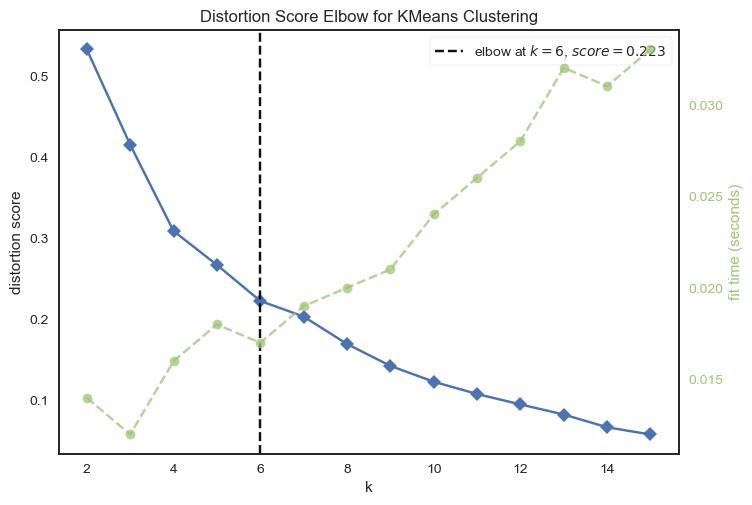

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [434]:
#from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

X = munich_grouped_clustering

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [439]:
# add clustering labels into the dataframe

#neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
munich_merged = munich_data
munich_merged = munich_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [440]:
munich_merged = munich_merged.sort_values(by=['Cluster Labels'], ascending=True)
munich_merged = munich_merged.astype({"Cluster Labels": "int32"}) # set cluster labels as integer
munich_merged

Neighborhood  Price in Euro/qm  \
0                                      Schwabing-West          7628.310   
8                               Neuhausen-Nymphenburg          7907.295   
7                             Obergiesing-Fasangarten          5364.330   
6                                            Sendling          6426.750   
12                            Untergiesing-Harlaching          6966.730   
2                                    Schwanthalerhöhe          6964.680   
24                         Aubing-Lochhausen-Langwied          5396.160   
23                             Feldmoching-Hasenbergl          4824.410   
16                                             Hadern          5991.380   
20                                     Trudering-Riem          5549.670   
3                                         Maxvorstadt          8460.265   
1                                       Au-Haidhausen          7872.340   
11                                     Altstadt-Lehel          9208.190   
4                        Ludwigsvorstadt-Isarvorstadt          8464.500   
10                                       Berg am Laim          5921.690   
13                                 Ramersdorf-Perlach          5590.750   
15  Thalkirchen-Obersendling-Forstenried-Fürstenri...          5852.460   
18                                 Pasing-Obermenzing          6061.300   
19                                        Bogenhausen          8399.890   
22                                Allach-Untermenzing          5699.770   
21                                 Schwabing-Freimann          6905.720   
5                                                Laim          5489.510   
9                                   Sendling-Westpark          6008.750   
17                                            Moosach          5643.690   
14                              Milbertshofen-Am Hart          5381.745   

    Area in km2  Population  Population Density   Latitude  Longitude  \
0          4.36       68935        15810.779817  48.168270  11.569873   
8         12.91      100213         7762.432223  48.154221  11.531517   
7          5.72       54498         9527.622378  48.111156  11.588909   
6          3.94       41256        10471.065990  48.118011  11.539083   
12         8.06       53243         6605.831266  48.114964  11.570189   
2          2.07       29611        14304.830918  48.133781  11.541057   
24        34.06       49072         1440.751615  48.165058  11.400222   
23        28.94       62069         2144.747754  48.218460  11.520409   
16         9.22       50165         5440.889371  48.118065  11.481842   
20        22.45       73479         3273.006682  48.123177  11.664078   
3          4.30       51834        12054.418605  48.151093  11.562418   
1          4.22       61654        14609.952607  48.128754  11.590536   
11         3.15       21126         6706.666667  48.137829  11.574582   
4          4.40       51933        11802.954545  48.130341  11.573366   
10         6.31       47000         7448.494453  48.123482  11.633451   
13        19.90      117918         5925.527638  48.100895  11.633371   
15        17.76       97689         5500.506757  48.084213  11.508051   
18        16.50       76348         4627.151515  48.152363  11.468434   
19        23.71       90025         3796.921130  48.154781  11.633484   
22        15.45       34277         2218.576052  48.195156  11.462974   
21        25.67       78657         3064.160499  48.189278  11.608582   
5          5.29       57111        10796.030246  48.139549  11.502166   
9          7.81       60498         7746.222791  48.118031  11.519333   
17        11.09       54872         4947.880974  48.179893  11.510571   
14        13.42       76559         5704.843517  48.182384  11.575043   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0                0            Restaurant          SportFitness   
8                0            Restaurant                  C

In [441]:
# create map
geo_munich = r'1_sehr_hoch.geo.json'
munich_clusters = folium.Map(location=[lat_munich, lon_munich], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(munich_merged['Latitude'], munich_merged['Longitude'], munich_merged['Neighborhood'], munich_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(munich_clusters)
       
munich_clusters

# 6. Develop some price estimation models (SLR, MLR and MPF)

Cluster 0 in red seems to be distinguished from other clusters by its fluent daily facilities. Let's take a closer look

In [442]:
# Cluster 2
df_c2 = munich_merged[munich_merged['Cluster Labels'] == 2]
df_c2.describe()

Price in Euro/qm  Area in km2   Population  Population Density  \
count           4.00000     4.000000      4.00000            4.000000   
mean         8501.32375     4.017500  46636.75000        11293.498106   
std           547.21180     0.583002  17619.85466         3310.409792   
min          7872.34000     3.150000  21126.00000         6706.666667   
25%          8313.28375     3.952500  44157.00000        10528.882576   
50%          8462.38250     4.260000  51883.50000        11928.686575   
75%          8650.42250     4.325000  54363.25000        12693.302105   
max          9208.19000     4.400000  61654.00000        14609.952607   

        Latitude  Longitude  Cluster Labels  
count   4.000000   4.000000             4.0  
mean   48.137005  11.575226             2.0  
std     0.010192   0.011580             0.0  
min    48.128754  11.562418             2.0  
25%    48.129944  11.570629             2.0  
50%    48.134085  11.573974             2.0  
75%    48.141145  11.578571             2.0  
max    48.151093  11.590536             2.0

In [443]:
df_c2.describe(include=[object])

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
count                4                     4                     4   
unique               4                     2                     2   
top     Altstadt-Lehel            Restaurant            Restaurant   
freq                 1                     2                     2   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                      4                     4                     4   
unique                     2                     3                     3   
top                 Shopping              Landmark              Nightpub   
freq                       2                     2                     2   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                      4                     4                     4   
unique                     3                     3                     3   
top                 Landmark                 Hotel                  Park   
freq                       2                     2                     2   

       9th Most Common Venue 10th Most Common Venue  
count                      4                      4  
unique                     3                      3  
top                     Park            Supermarket  
freq                       2                      2

In [444]:
# Cluster 0
df_c0 = munich_merged[munich_merged['Cluster Labels'] == 0]
df_c0.describe()

Price in Euro/qm  Area in km2     Population  Population Density  \
count          6.000000     6.000000       6.000000            6.000000   
mean        6876.349167     6.176667   57959.333333        10747.093765   
std          909.132203     3.853853   24587.360905         3630.977044   
min         5364.330000     2.070000   29611.000000         6605.831266   
25%         6561.232500     4.045000   44252.750000         8203.729762   
50%         6965.705000     5.040000   53870.500000         9999.344184   
75%         7462.915000     7.475000   65325.750000        13346.389686   
max         7907.295000    12.910000  100213.000000        15810.779817   

        Latitude  Longitude  Cluster Labels  
count   6.000000   6.000000             6.0  
mean   48.133404  11.556771             0.0  
std     0.023328   0.022725             0.0  
min    48.111156  11.531517             0.0  
25%    48.115726  11.539577             0.0  
50%    48.125896  11.555465             0.0  
75%    48.149111  11.570110             0.0  
max    48.168270  11.588909             0.0

In [445]:
df_c0.describe(include=[object])

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
count                6                     6                     6   
unique               6                     1                     2   
top     Schwabing-West            Restaurant                  Cafe   
freq                 1                     6                     4   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                      6                     6                     6   
unique                     3                     4                     6   
top                 Nightpub                 Snack                  Park   
freq                       3                     2                     1   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                      6                     6                     6   
unique                     4                     5                     4   
top                 Shopping              Shopping                 Snack   
freq                       3                     2                     3   

       9th Most Common Venue 10th Most Common Venue  
count                      6                      6  
unique                     5                      4  
top                     Park            Supermarket  
freq                       2                      2

In [446]:
# Cluster 3
df_c3 = munich_merged[munich_merged['Cluster Labels'] == 3]
df_c3.describe()

Price in Euro/qm  Area in km2     Population  Population Density  \
count          5.000000     5.000000       5.000000            5.000000   
mean        6365.218000    16.836000   85796.000000         5459.720299   
std         1150.184206     6.488515   26389.131731         1381.297805   
min         5590.750000     6.310000   47000.000000         3796.921130   
25%         5852.460000    16.500000   76348.000000         4627.151515   
50%         5921.690000    17.760000   90025.000000         5500.506757   
75%         6061.300000    19.900000   97689.000000         5925.527638   
max         8399.890000    23.710000  117918.000000         7448.494453   

        Latitude  Longitude  Cluster Labels  
count   5.000000   5.000000             5.0  
mean   48.123146  11.575357             3.0  
std     0.031086   0.080750             0.0  
min    48.084213  11.468434             3.0  
25%    48.100895  11.508051             3.0  
50%    48.123482  11.633371             3.0  
75%    48.152363  11.633451             3.0  
max    48.154781  11.633484             3.0

In [447]:
df_c3.describe(include=[object])

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
count              5                     5                     5   
unique             5                     1                     3   
top     Berg am Laim            Restaurant           Supermarket   
freq               1                     5                     2   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                      5                     5                     5   
unique                     3                     2                     4   
top              Supermarket          SportFitness        PublicTranport   
freq                       3                     3                     2   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                      5                     5                     5   
unique                     3                     3                     3   
top                 Pharmacy              Pharmacy                 Hotel   
freq                       3                     2                     3   

       9th Most Common Venue 10th Most Common Venue  
count                      5                      5  
unique                     4                      5  
top                 Nightpub                   Bank  
freq                       2                      1

In [448]:
# Cluster 4
df_c4 = munich_merged[munich_merged['Cluster Labels'] == 4]
df_c4.describe()

Price in Euro/qm  Area in km2   Population  Population Density  \
count          6.000000     6.000000      6.00000            6.000000   
mean        5854.864167    13.121667  60329.00000         5746.285680   
std          557.485959     7.164458  16236.98323         3155.229528   
min         5381.745000     5.290000  34277.00000         2218.576052   
25%         5528.055000     8.630000  55431.75000         3535.090617   
50%         5671.730000    12.255000  58804.50000         5326.362245   
75%         5931.505000    14.942500  72543.75000         7235.877973   
max         6905.720000    25.670000  78657.00000        10796.030246   

        Latitude  Longitude  Cluster Labels  
count   6.000000   6.000000             6.0  
mean   48.167377  11.529778             4.0  
std     0.031121   0.052844             0.0  
min    48.118031  11.462974             4.0  
25%    48.149635  11.504267             4.0  
50%    48.181139  11.514952             4.0  
75%    48.187554  11.561115             4.0  
max    48.195156  11.608582             4.0

In [449]:
df_c4.describe(include=[object])

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
count                    6                     6                     6   
unique                   6                     1                     2   
top     Schwabing-Freimann            Restaurant              Shopping   
freq                     1                     6                     4   

       3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
count                      6                     6                     6   
unique                     4                     4                     6   
top                    Hotel          SportFitness        PublicTranport   
freq                       3                     3                     1   

       6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
count                      6                     6                     6   
unique                     5                     4                     4   
top                     Cafe              Pharmacy        PublicTranport   
freq                       2                     3                     2   

       9th Most Common Venue 10th Most Common Venue  
count                      6                      6  
unique                     6                      6  
top                     Park         PublicTranport  
freq                       1                      1

In [450]:
# Cluster 1
df_c1 = munich_merged[munich_merged['Cluster Labels'] == 1]
df_c1.describe()

Price in Euro/qm  Area in km2    Population  Population Density  \
count          4.000000     4.000000      4.000000            4.000000   
mean        5440.405000    23.667500  58696.250000         3074.848855   
std          481.981933    10.739582  11479.163076         1748.597161   
min         4824.410000     9.220000  49072.000000         1440.751615   
25%         5253.222500    19.142500  49891.750000         1968.748719   
50%         5472.915000    25.695000  56117.000000         2708.877218   
75%         5660.097500    30.220000  64921.500000         3814.977354   
max         5991.380000    34.060000  73479.000000         5440.889371   

        Latitude  Longitude  Cluster Labels  
count   4.000000   4.000000             4.0  
mean   48.156189  11.516638             1.0  
std     0.046546   0.110327             0.0  
min    48.118065  11.400222             1.0  
25%    48.121899  11.461437             1.0  
50%    48.144117  11.501125             1.0  
75%    48.178409  11.556326             1.0  
max    48.218460  11.664078             1.0

In [451]:
df_c1.describe(include=[object])

Neighborhood 1st Most Common Venue  \
count                            4                     4   
unique                           4                     1   
top     Aubing-Lochhausen-Langwied            Restaurant   
freq                             1                     4   

       2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
count                      4                     4                     4   
unique                     2                     3                     4   
top              Supermarket           Supermarket                  Cafe   
freq                       2                     2                     1   

       5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
count                      4                     4                     4   
unique                     4                     3                     3   
top                     Bank                Bakery              Pharmacy   
freq                       1                     2                     2   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
count                      4                     4                      4  
unique                     3                     3                      4  
top                 Landmark                 Snack                   Park  
freq                       2                     2                      1

positive correlation: café, snack	culture	nightpub

negative correlation: supermarket	Pharmacy

### Price function by regression

In [452]:
df = munich_cityscores
df

Neighborhood  Price in Euro/qm  \
0                                      Schwabing-West          7628.310   
1                                       Au-Haidhausen          7872.340   
2                                    Schwanthalerhöhe          6964.680   
3                                         Maxvorstadt          8460.265   
4                        Ludwigsvorstadt-Isarvorstadt          8464.500   
5                                                Laim          5489.510   
6                                            Sendling          6426.750   
7                             Obergiesing-Fasangarten          5364.330   
8                               Neuhausen-Nymphenburg          7907.295   
9                                   Sendling-Westpark          6008.750   
10                                       Berg am Laim          5921.690   
11                                     Altstadt-Lehel          9208.190   
12                            Untergiesing-Harlaching          6966.730   
13                                 Ramersdorf-Perlach          5590.750   
14                              Milbertshofen-Am Hart          5381.745   
15  Thalkirchen-Obersendling-Forstenried-Fürstenri...          5852.460   
16                                             Hadern          5991.380   
17                                            Moosach          5643.690   
18                                 Pasing-Obermenzing          6061.300   
19                                        Bogenhausen          8399.890   
20                                     Trudering-Riem          5549.670   
21                                 Schwabing-Freimann          6905.720   
22                                Allach-Untermenzing          5699.770   
23                             Feldmoching-Hasenbergl          4824.410   
24                         Aubing-Lochhausen-Langwied          5396.160   

    Area in km2  Population  Population Density  Bakery  Bank  Cafe  Culture  \
0          4.36       68935        15810.779817       3     0     8        6   
1          4.22       61654        14609.952607       1     0    18        8   
2          2.07       29611        14304.830918       0     0    14        5   
3          4.30       51834        12054.418605       4     0    18        5   
4          4.40       51933        11802.954545       0     0    25        7   
5          5.29       57111        10796.030246       6     3     3        3   
6          3.94       41256        10471.065990       3     0    12        5   
7          5.72       54498         9527.622378       2     0     8        1   
8         12.91      100213         7762.432223       4     0     9        3   
9          7.81       60498         7746.222791       4     2     5        6   
10         6.31       47000         7448.494453       4     1     1        0   
11         3.15       21126         6706.666667       0     0    20        5   
12         8.06       53243         6605.831266       1     0    17        1   
13        19.90      117918         5925.527638       2     0     5        1   
14        13.42       76559         5704.843517       3     1     7        3   
15        17.76       97689         5500.506757       4     3     3        2   
16         9.22       50165         5440.889371       1     3     3        0   
17        11.09       54872         4947.880974       5     0     1        1   
18        16.50       76348         4627.151515       1     0     7        2   
19        23.71       90025         3796.921130       2     2     6        1   
20        22.45       73479         3273.006682       4     0     3        0   
21        25.67       78657         3064.160499       1     1     3        2   
22        15.45       34277         2218.576052       2     0     0        0   
23        28.94       62069         2144.747754       2     0     3        0   
24        34.06       49072         1440.751615       1     0     0        0   

    Hotel

In [453]:
df.corr()

Price in Euro/qm  Area in km2  Population  \
Price in Euro/qm            1.000000    -0.407529   -0.124438   
Area in km2                -0.407529     1.000000    0.457620   
Population                 -0.124438     0.457620    1.000000   
Population Density          0.462490    -0.811897   -0.215528   
Bakery                     -0.333092    -0.061093    0.268510   
Bank                       -0.186172     0.027355    0.204213   
Cafe                        0.759212    -0.594470   -0.286268   
Culture                     0.621016    -0.635295   -0.184385   
Hotel                       0.166855    -0.243319   -0.109439   
Landmark                    0.748047    -0.502915   -0.265816   
Nightpub                    0.586076    -0.693341   -0.403724   
Park                        0.499297    -0.276167    0.057680   
Pharmacy                   -0.421073     0.035688    0.312684   
PublicTranport             -0.435510     0.312850    0.195124   
Restaurant                  0.401825    -0.612554    0.120426   
Shopping                    0.111006    -0.336913    0.077096   
Snack                       0.474879    -0.434477   -0.046873   
SportFitness               -0.106851    -0.297664    0.203183   
Supermarket                -0.460902     0.040455    0.223493   

                    Population Density    Bakery      Bank      Cafe  \
Price in Euro/qm              0.462490 -0.333092 -0.186172  0.759212   
Area in km2                  -0.811897 -0.061093  0.027355 -0.594470   
Population                   -0.215528  0.268510  0.204213 -0.286268   
Population Density            1.000000  0.016392 -0.123559  0.618052   
Bakery                        0.016392  1.000000  0.341092 -0.452574   
Bank                         -0.123559  0.341092  1.000000 -0.374252   
Cafe                          0.618052 -0.452574 -0.374252  1.000000   
Culture                       0.798864 -0.128886 -0.137870  0.727202   
Hotel                         0.207165  0.104109  0.080578  0.183701   
Landmark                      0.435779 -0.231327 -0.178105  0.737849   
Nightpub                      0.669449 -0.208462 -0.338797  0.849744   
Park                          0.307454 -0.133638 -0.034817  0.442638   
Pharmacy                     -0.274379  0.609394  0.477336 -0.470715   
PublicTranport               -0.448164  0.267723  0.612425 -0.616021   
Restaurant                    0.727312  0.070743 -0.195500  0.484583   
Shopping                      0.203345  0.050110  0.048199  0.254457   
Snack                         0.378938 -0.295420 -0.242941  0.690265   
SportFitness                  0.313388  0.248024  0.102764 -0.049504   
Supermarket                  -0.220867  0.575922  0.523014 -0.542657   

                     Culture     Hotel  Landmark  Nightpub      Park  \
Price in Euro/qm    0.621016  0.166855  0.748047  0.586076  0.499297   
Area in km2        -0.635295 -0.243319 -0.502915 -0.693341 -0.276167   
Population         -0.184385 -0.109439 -0.265816 -0.403724  0.057680   
Population Density  0.798864  0.207165  0.435779  0.669449  0.307454   
Bakery             -0.128886  0.104109 -0.231327 -0.208462 -0.133638   
Bank               -0.137870  0.080578 -0.178105 -0.338797 -0.034817   
Cafe                0.727202  0.183701  0.737849  0.849744  0.442638   
Culture             1.000000  0.315005  0.580056  0.640296  0.478355   
Hotel               0.315005  1.000000  0.133033  0.338322  0.081332   
Landmark            0.580056  0.133033  1.000000  0.607180  0.321561   
Nightpub            0.640296  0.338322  0.607180  1.000000  0.411202   
Park                0.478355  0.081332  0.321561  0.411202  1.000000   
Pharmacy           -0.285108  0.195405 -0.288486 -0.304535 -0.040775   
PublicTranport     -0.531078 -0.229513 -0.400030 -0.724108 -0.381473   
Restaurant          0.484989  0.165135  0.226715  0.649649  0.442024   
Shopping            0.392006  0.377267  0.259421  0.206794  0.040641   
Snack               0.477727  0.334996  0.387214  0.62

In [454]:
y_data = df['Price in Euro/qm']

Variables with relatively high correlation to the price (<-0.4 or >0.4): Cafe, Landmark, Culture, Nightpub, Park, Pharmacy, PublicTranport, Restaurant, Snack, Supermarket ($x1, x2,..., x10$)

In [455]:
#cols_to_drop = ['Price in Euro/qm', 'Neighborhood', 'Area in km2', 'Population', 'Population Density']
cols_of_interest = ['Cafe', 'Landmark', 'Culture', 'Nightpub', 'Park', 'Snack', 'PublicTranport', 'Supermarket', 'Pharmacy']
#df = df[cols_of_interest]
x_data=df[cols_of_interest]
x_data.head()

Cafe  Landmark  Culture  Nightpub  Park  Snack  PublicTranport  \
0     8         3        6         6     5      3               0   
1    18         7        8        10     3      2               0   
2    14         1        5         9     2      4               0   
3    18         8        5        10     4      2               0   
4    25         7        7         8     4      8               0   

   Supermarket  Pharmacy  
0            2         0  
1            3         0  
2            1         0  
3            1         0  
4            2         1

In [456]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.20, random_state=1)
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 5
number of training samples: 20


In [457]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

## a. Single Linear Regression (SLR)

In [458]:
lre=LinearRegression()
lre.fit(x_train[['Cafe']], y_train)

LinearRegression()

In [459]:
lre.score(x_train[['Cafe']], y_train)

0.570714465991117

In [460]:
lre.score(x_test[['Cafe']], y_test)

0.5890650298731998

In [461]:
Rcross = cross_val_score(lre, x_data[['Cafe']], y_data, cv=3)
Rcross

array([0.51885359, 0.66583818, 0.1493539 ])

In [462]:
print("The mean of the folds are", Rcross.mean(), "and the standard deviation is" , Rcross.std())

The mean of the folds are 0.4446818897686969 and the standard deviation is 0.21727875150803175


In [463]:
from sklearn.metrics import r2_score

# Find the R^2
print("SLR Model:")
print('The R-square of the train group is: ', lre.score(x_train[['Cafe']], y_train))
print('The R-square of the test group is: ', lre.score(x_test[['Cafe']], y_test))
print('The R-square of the entire group is: ', lre.score(x_data[['Cafe']], y_data))

SLR Model:
The R-square of the train group is:  0.570714465991117
The R-square of the test group is:  0.5890650298731998
The R-square of the entire group is:  0.5760722720061815


### Price Prediction by SLR 

In [464]:
yhat = cross_val_predict(lre,x_data[['Cafe']], y_data,cv=3)
yhat[0:25]

array([6604.01995042, 8027.20499739, 7457.9309786 , 8027.20499739,
       9023.43453027, 5892.42742693, 7173.29396921, 6604.01995042,
       6746.33845511, 6255.60528242, 5748.94111647, 8155.59590474,
       7775.59778028, 6255.60528242, 6508.9373654 , 6002.27319944,
       6002.27319944, 5467.06173035, 6318.36835616, 6176.48391853,
       5750.83060562, 5750.83060562, 5325.17729272, 5750.83060562,
       5325.17729272])

## b. Multiple Linear Regression (MLR)

In [465]:
from sklearn.preprocessing import PolynomialFeatures

In [466]:
pr1=PolynomialFeatures(degree=1) # number of degree
pr1

PolynomialFeatures(degree=1)

In [467]:
x_train_pr1 = pr1.fit_transform(x_train[cols_of_interest])
x_test_pr1 = pr1.fit_transform(x_test[cols_of_interest])
x_data_pr1 = pr1.fit_transform(x_data[cols_of_interest])

In [468]:
#x_data[cols_of_interest]

In [469]:
x_train_pr1.shape # 10 features

(20, 10)

In [470]:
poly1 = LinearRegression()
poly1.fit(x_train_pr1, y_train)

LinearRegression()

In [471]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.legend()
    plt.title(Title)
    plt.xlabel('Price in Euro/qm')
    plt.ylabel('Proportion of Neighborhoods')

    plt.show()
    plt.close()

In [472]:
def PollyPlot(xtrain, xtest, y_train, y_test, lr,poly_transform):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))
    
    
    #training data 
    #testing data 
    # lr:  linear regression object 
    #poly_transform:  polynomial transformation object 
 
    xmax=max([xtrain.values.max(), xtest.values.max()])

    xmin=min([xtrain.values.min(), xtest.values.min()])

    x=np.arange(xmin, xmax, 0.1)


    plt.plot(xtrain, y_train, 'ro', label='Training Data')
    plt.plot(xtest, y_test, 'go', label='Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1, 1))), label='Predicted Function')
    plt.ylim([0, 12000])
    plt.ylabel('Price in Euro/qm')
    plt.legend()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


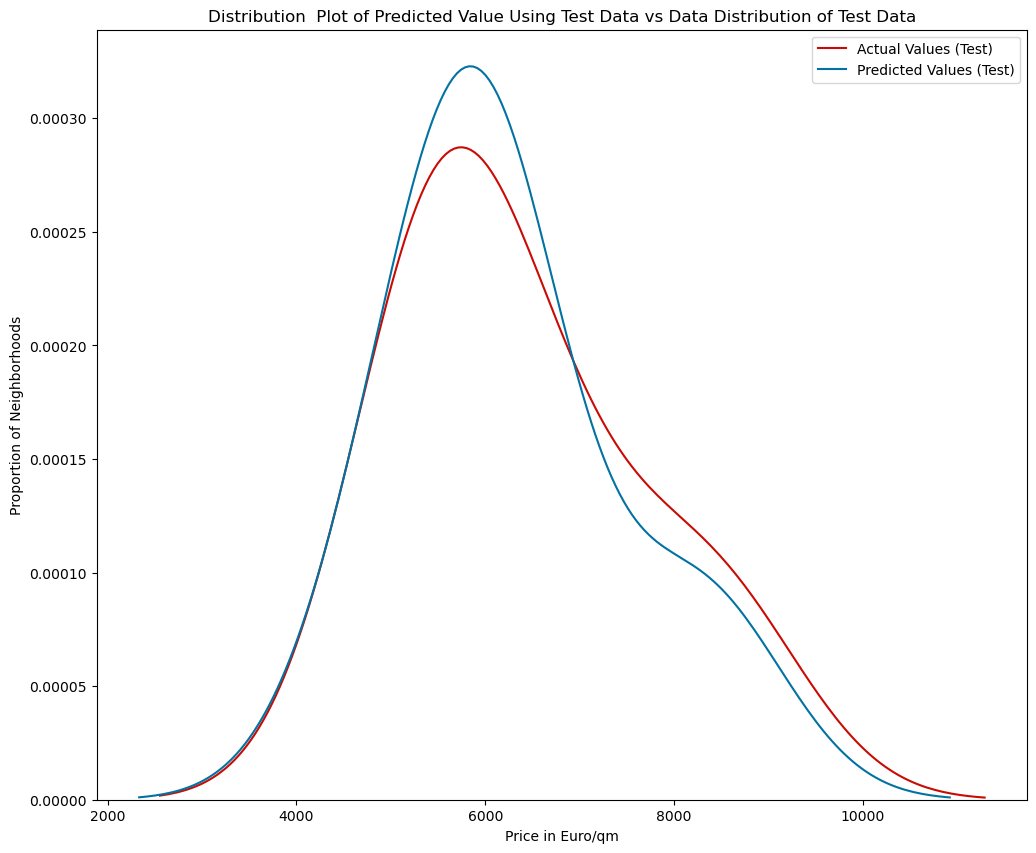

In [473]:
# Predict the test group, MLR
mpl.style.use('default')

y_hat_test_pr1 = poly1.predict(x_test_pr1)

Title='Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,y_hat_test_pr1,"Actual Values (Test)","Predicted Values (Test)",Title)  # good result by poly (order=2, multiple variable polynomial)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


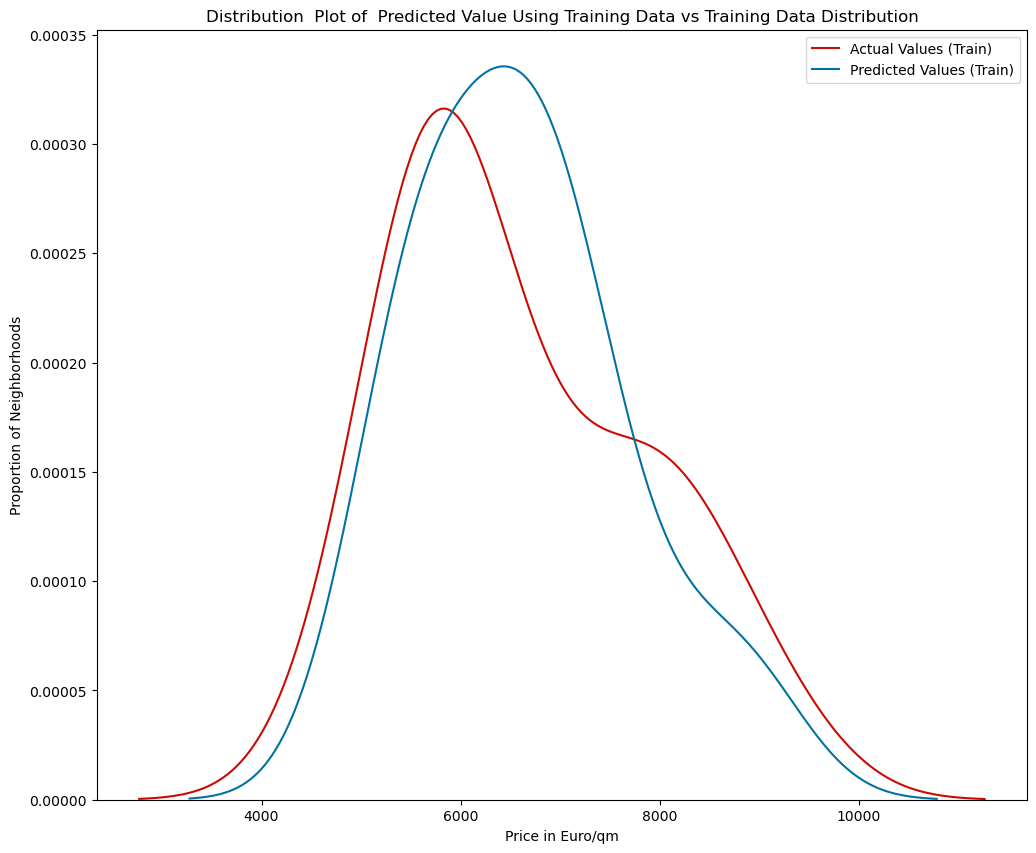

In [474]:
y_hat_train_pr1 = poly1.predict(x_train_pr1)

Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, y_hat_train_pr1, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [475]:
List_train = x_train.index
List_train

Int64Index([10, 18, 19, 4, 2, 20, 6, 7, 22, 1, 16, 0, 15, 24, 23, 9, 8, 12, 11,
            5],
           dtype='int64')

In [476]:
#for n in List_train:
#    print(munich_cityscores.iloc[[n]].Neighborhood)

In [477]:
yhat_train_MLR = poly1.predict(x_train_pr1)
yhat_train_MLR

array([5032.96582605, 6386.50818281, 7076.85115411, 8531.76510817,
       6632.67938181, 5258.93900989, 6571.28446493, 6401.88879767,
       5668.15054952, 7863.53410245, 6268.42846813, 6953.80314019,
       5452.99567078, 5605.50750896, 5714.91329038, 7123.97636388,
       7046.7957656 , 7443.01227473, 9024.47255743, 5939.64338249])

In [478]:
List_test = x_test.index
List_test

Int64Index([14, 13, 17, 3, 21], dtype='int64')

In [479]:
#for n in List_test:
#    print(munich_cityscores.iloc[[n]].Neighborhood)

14    Milbertshofen-Am Hart
Name: Neighborhood, dtype: object
13    Ramersdorf-Perlach
Name: Neighborhood, dtype: object
17    Moosach
Name: Neighborhood, dtype: object
3    Maxvorstadt
Name: Neighborhood, dtype: object
21    Schwabing-Freimann
Name: Neighborhood, dtype: object


In [480]:
yhat_test_MLR = poly1.predict(x_test_pr1)
yhat_test_MLR

array([6157.1569699 , 5948.33837395, 4979.23755673, 8273.99768642,
       5922.30776109])

In [482]:
from sklearn.metrics import r2_score

# Find the R^2
print("MLR Model:")
print('The R-square of the train group is: ', poly1.score(x_train_pr1, y_train))
print('The R-square of the test group is: ', poly1.score(x_test_pr1, y_test))
print('The R-square of the entire group is: ', poly1.score(x_data_pr1, y_data))

MLR Model:
The R-square of the train group is:  0.731604826512386
The R-square of the test group is:  0.678830788649489
The R-square of the entire group is:  0.7230274922061546


## c. Multivariate Polynomial Function

In [483]:
from sklearn.preprocessing import PolynomialFeatures

In [484]:
pr2=PolynomialFeatures(degree=2) # number of degree
pr2

PolynomialFeatures()

In [485]:
x_train_pr2 = pr2.fit_transform(x_train[cols_of_interest])
x_test_pr2 = pr2.fit_transform(x_test[cols_of_interest])
x_data_pr2 = pr2.fit_transform(x_data[cols_of_interest])

In [486]:
x_train_pr2.shape # 36 features

(20, 55)

In [487]:
poly2 = LinearRegression()
poly2.fit(x_train_pr2, y_train)

LinearRegression()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


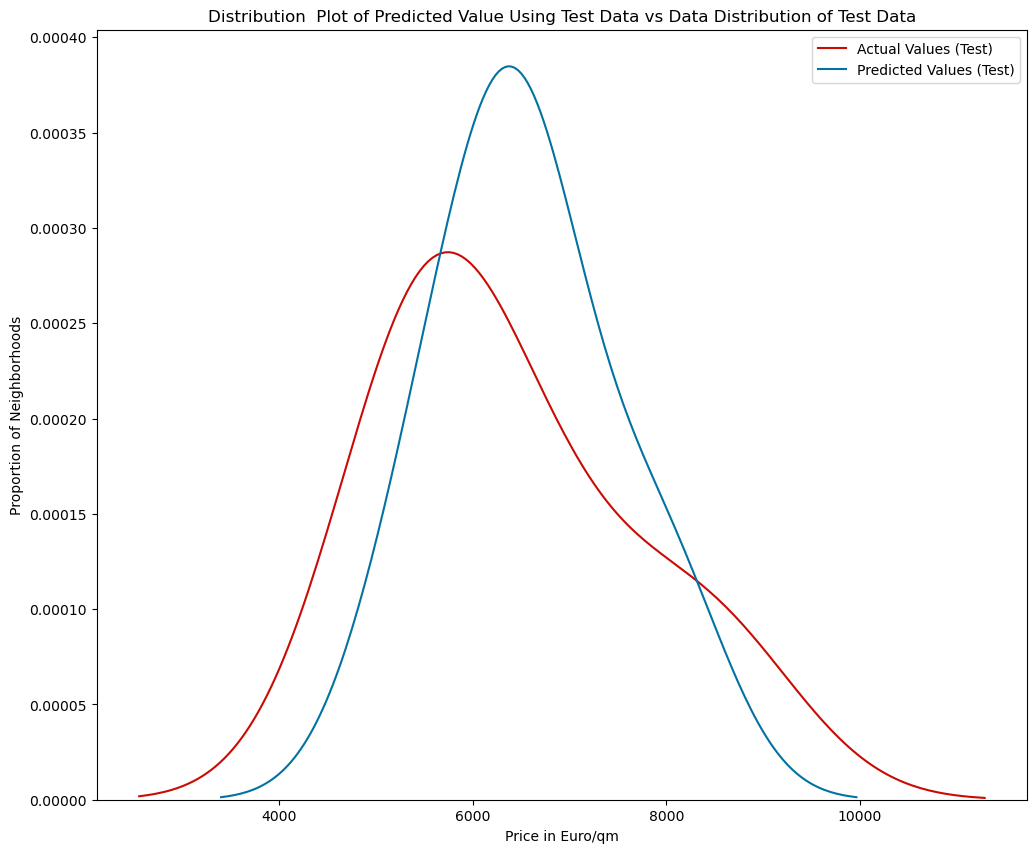

In [488]:
y_hat_test_pr2 = poly2.predict(x_test_pr2)

Title='Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,y_hat_test_pr2,"Actual Values (Test)","Predicted Values (Test)",Title)  # good result by poly (order=2, multiple variable polynomial)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


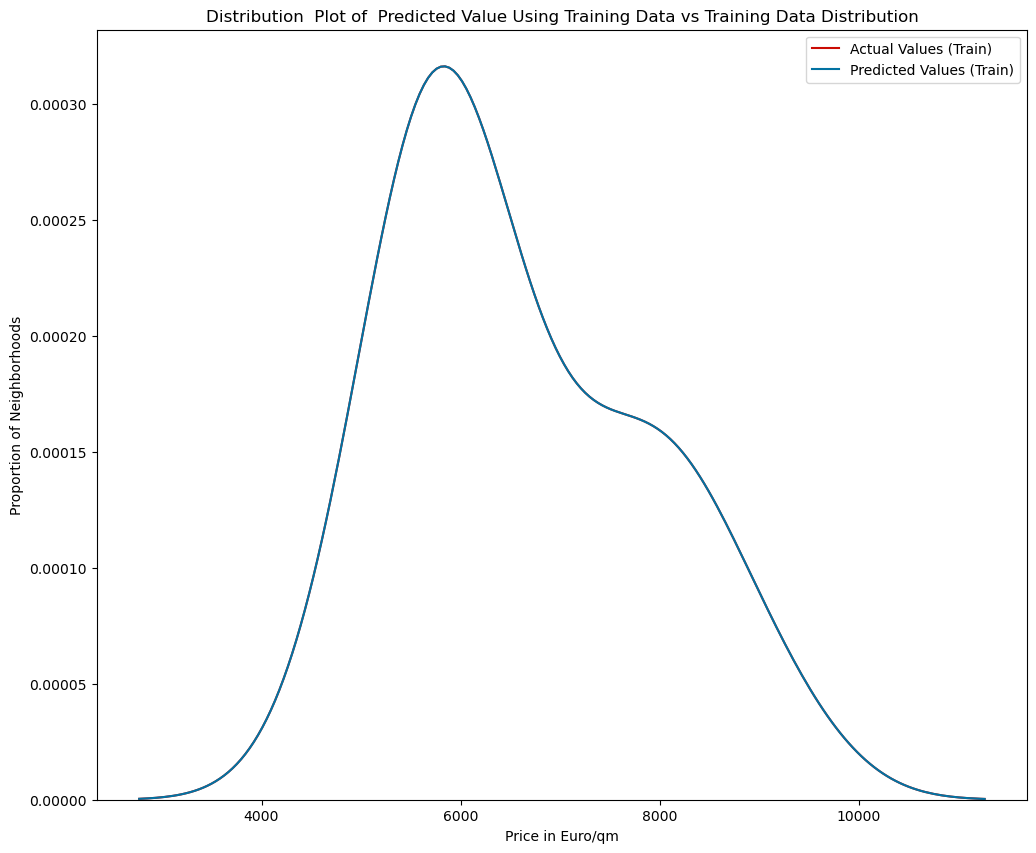

In [489]:
y_hat_train_pr2 = poly2.predict(x_train_pr2)

Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, y_hat_train_pr2, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [490]:
from sklearn.metrics import r2_score

# Find the R^2
print("MPF Model:")
print('The R-square of the train group is: ', poly2.score(x_train_pr2, y_train))
print('The R-square of the test group is: ', poly2.score(x_test_pr2, y_test))
print('The R-square of the entire group is: ', poly2.score(x_data_pr2, y_data))

MPF Model:
The R-square of the train group is:  1.0
The R-square of the test group is:  0.5367417524084587
The R-square of the entire group is:  0.9139986956697428


In [491]:
List_train = x_train.index
List_train

Int64Index([10, 18, 19, 4, 2, 20, 6, 7, 22, 1, 16, 0, 15, 24, 23, 9, 8, 12, 11,
            5],
           dtype='int64')

In [492]:
yhat_train_MPF = poly2.predict(x_train_pr2)
yhat_train_MPF

array([5921.69 , 6061.3  , 8399.89 , 8464.5  , 6964.68 , 5549.67 ,
       6426.75 , 5364.33 , 5699.77 , 7872.34 , 5991.38 , 7628.31 ,
       5852.46 , 5396.16 , 4824.41 , 6008.75 , 7907.295, 6966.73 ,
       9208.19 , 5489.51 ])

In [493]:
List_test = x_test.index
List_test

Int64Index([14, 13, 17, 3, 21], dtype='int64')

In [494]:
yhat_test_MPF = poly2.predict(x_test_pr2)
yhat_test_MPF

array([6796.97443058, 5412.26021503, 6339.41347447, 7952.00383362,
       6308.69539453])

## Optional: check if a Pipline can improve the 2nd-order Polynomial Fit

In [495]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [496]:
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=2,include_bias=False)), ('model',LinearRegression())]

In [497]:
pipe=Pipeline(Input)
pipe

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [498]:
Z = x_train
y = y_train

In [499]:
pipe.fit(Z,y)

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [500]:
ypipe_hat_train = pipe.predict(Z)
ypipe_hat_train[0:5]

array([5921.69, 6061.3 , 8399.89, 8464.5 , 6964.68])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


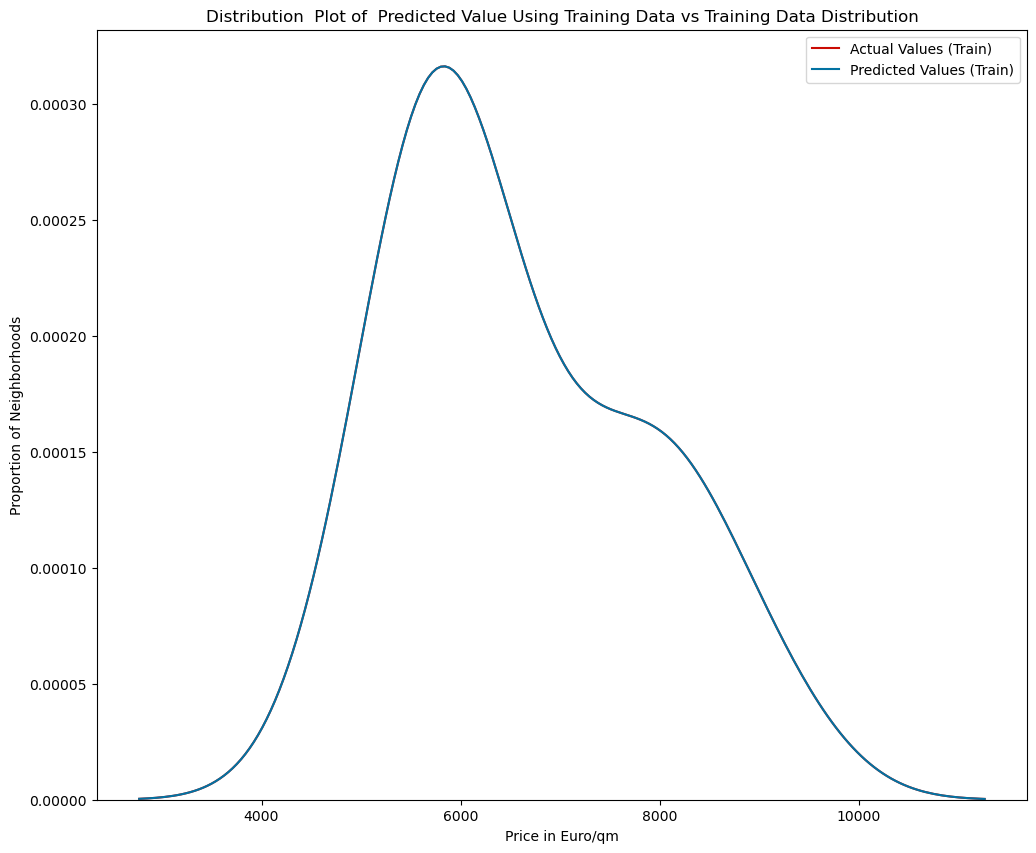

In [501]:
# Plot for the train group

Title = 'Distribution  Plot of  Predicted Value Using Training Data vs Training Data Distribution'
DistributionPlot(y_train, ypipe_hat_train , "Actual Values (Train)", "Predicted Values (Train)", Title)

In [502]:
Z_test = x_test
ypipe_hat_test = pipe.predict(Z_test)
ypipe_hat_test[0:10]



array([5542.12034941, 6035.05317005, 4705.29920127, 7690.35224733,
       7419.21892073])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


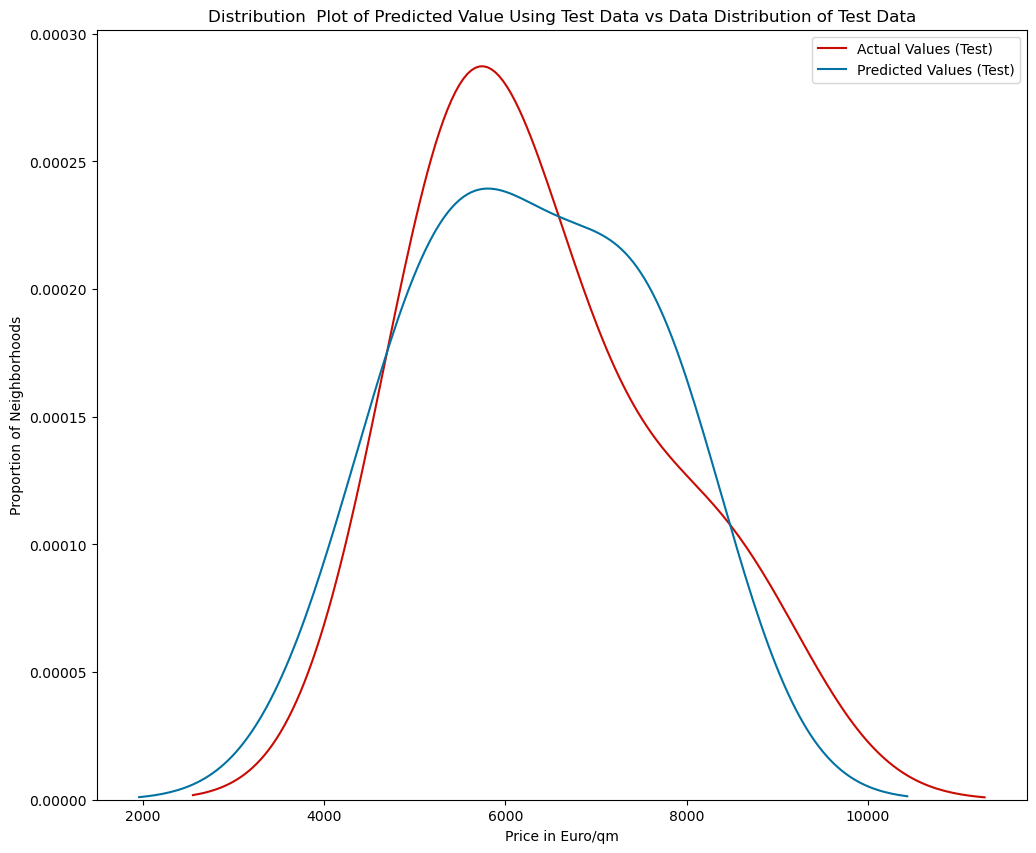

In [503]:
# Plot for the test group

Title='Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_test,ypipe_hat_test,"Actual Values (Test)","Predicted Values (Test)",Title)  # good result by poly (order=2, multiple variable polynomial)

In [504]:
from sklearn.metrics import r2_score

In [505]:
ypipe_hat_train = pipe.predict(Z)

# Find the R^2
print('The R-square of the test group is: ', pipe.score(x_test, y_test))

The R-square of the test group is:  0.710213420948532


In [506]:
# Find the R^2
print('The R-square of the entire group is: ', pipe.score(x_data, y_data))

The R-square of the entire group is:  0.9462027413318642


# 7. Final examination of price models with a few new test data

In [507]:
df_price_original

Neighborhood  Price in Euro/qm
0                                      Altstadt-Lehel           9208.19
1                     Maxvorstadt-Universitätsviertel           8952.17
2                                           Schwabing           8673.53
3                        Ludwigsvorstadt-Isarvorstadt           8464.50
4                           Altbogenhausen-Herzogpark           8399.89
5                                         Nymphenburg           8394.83
6                                         Maxvorstadt           7968.36
7                                       Au-Haidhausen           7872.34
8                                          Harlaching           7837.55
9                                      Schwabing-West           7628.31
10                                          Neuhausen           7419.76
11                                   Schwanthalerhöhe           6964.68
12                          Oberföhring-Englschalking           6548.61
13                                           Sendling           6426.75
14                                Alte Heide-Hirschau           6304.83
15                                       Untergiesing           6095.91
16                                 Pasing-Obermenzing           6061.30
17                                  Sendling-Westpark           6008.75
18                                             Hadern           5991.38
19                                       Berg am Laim           5921.69
20                                      Milbertshofen           5886.83
21  Thalkirchen-Obersendling-Forstenried-Fürstenri...           5852.46
22                                Allach-Untermenzing           5699.77
23                                            Moosach           5643.69
24                                 Ramersdorf-Perlach           5590.75
25                                     Trudering-Riem           5549.67
26                           Johanneskirchen-Daglfing           5538.43
27                                               Laim           5489.51
28                         Aubing-Lochhausen-Langwied           5396.16
29                                        Obergiesing           5364.33
30                                           Freimann           5137.91
31                                            Am Hart           4876.66
32                             Feldmoching-Hasenbergl           4824.41

In [508]:
df_price_new = df_price_original.iloc[[12,14,26]]
dict_translate_new = {'Johanneskirchen-Daglfing':'Daglfing'}
df_price_new = df_price_new.replace({'Neighborhood' : dict_translate_new})
df_price_new = df_price_new.sort_values(by=['Price in Euro/qm'], ascending=False)
df_price_new = df_price_new.reset_index(drop=True)
df_price_new

Neighborhood  Price in Euro/qm
0  Oberföhring-Englschalking           6548.61
1        Alte Heide-Hirschau           6304.83
2                   Daglfing           5538.43

In [509]:
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_bezirk_new = pd.DataFrame(columns=column_names)
df_bezirk_new = df_bezirk_new.astype({'Latitude': 'float32', 'Longitude': 'float32'})
df_bezirk_new

Empty DataFrame
Columns: [Neighborhood, Latitude, Longitude]
Index: []

In [510]:
# Get the center location of Munich city

geolocator = Nominatim(user_agent="munich_agent")
location = geolocator.geocode("Munich")
lat_munich = location.latitude
lon_munich = location.longitude
print('The geographical coordinate of Munich City are {}, {}.'.format(lat_munich, lon_munich))

The geographical coordinate of Munich City are 48.1371079, 11.5753822.


In [511]:
for i in range(df_price_new.shape[0]):
    Bezirk = df_price_new.loc[i, 'Neighborhood']
    address = '{}, Munich'.format(Bezirk)
    geolocator = Nominatim(user_agent="munich_agent")
    location = geolocator.geocode(address)
    df_bezirk_new.at[i, 'Neighborhood'] = Bezirk
    df_bezirk_new.at[i, 'Latitude'] = location.latitude
    df_bezirk_new.at[i, 'Longitude'] = location.longitude


In [512]:
df_result_new = pd.merge(df_price_new, df_bezirk_new, on="Neighborhood")
df_result_new

Neighborhood  Price in Euro/qm   Latitude  Longitude
0  Oberföhring-Englschalking           6548.61  48.156456  11.642028
1        Alte Heide-Hirschau           6304.83  48.174774  11.603891
2                   Daglfing           5538.43  48.149639  11.649305

In [513]:
munich_data_new = df_result_new
munich_venues_new = getNearbyVenues(names = munich_data_new['Neighborhood'],
                                latitudes = munich_data_new['Latitude'],
                                longitudes = munich_data_new['Longitude']
                                )

Oberföhring-Englschalking
Alte Heide-Hirschau
Daglfing


In [514]:
munich_venues.groupby('Neighborhood').count()
print('There are {} uniques categories within {} neighborhoods.'.format(len(munich_venues['VenueCategory'].unique()), len(munich_venues['Neighborhood'].unique())))

There are 228 uniques categories within 25 neighborhoods.


In [515]:
munich_venues['VenueCategory'].value_counts()

Café                                        115
Supermarket                                 111
German Restaurant                            97
Italian Restaurant                           96
Hotel                                        85
Drugstore                                    61
Bakery                                       60
Plaza                                        55
Greek Restaurant                             49
Ice Cream Shop                               45
Bus Stop                                     35
Park                                         35
Asian Restaurant                             34
Restaurant                                   31
Coffee Shop                                  31
Gym / Fitness Center                         28
Trattoria/Osteria                            27
Beer Garden                                  27
Bar                                          26
Vietnamese Restaurant                        25
Doner Restaurant                        

In [516]:
df = munich_venues_new.copy(deep=True)
df.shape

(181, 7)

In [517]:
searchfor_restaurant = [' Restaurant', 'Breakfast', 'Steakhouse', 'Burger', 'Diner','Trattoria/Osteria', 'Taverna',
                        'Beer Garden', 'Brewery', 'BBQ', 'Manti Place', 'Fried Chicken']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_restaurant)), 'VenueCategory'] = 'Restaurant'

searchfor_coffee = ["Coffee","Café", 'Tea', "Ice Cream", 'Cafeteria']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_coffee)), 'VenueCategory'] = 'Cafe'

searchfor_bar = ["Pub","Bar","Club", 'Beer', 'Gastropub', 'Nightclub', 'Brewery', 'Cocktail', 'Speakeasy']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_bar)), 'VenueCategory'] = 'Nightpub'

searchfor_transport = [' Stop', ' Station']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_transport)), 'VenueCategory'] = 'PublicTranport'

searchfor_snack = ['Pizza','Burrito', 'Bistro', 'Cupcake', 'Sandwich', 'Soup', 'Salad', 'Food', 'Snack']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_snack)), 'VenueCategory'] = 'Snack'

searchfor_shop = ["Shop","Store","Boutique", "Grocery", 'shop', 'Retailer', 'Bodega', 'Butcher', 'Newsstand',
                  'Mall', 'Garden Center']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_shop)), 'VenueCategory'] = 'Shopping'

searchfor_sport = ['Sport', 'Fitness', 'Yoga', 'Gym', 'Pool', 'Soccer Field', 'Spa', 'Lounge', 'Stadium', 'Bowling', 'Hockey',
                   'Tennis','Skating','Escape Room']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_sport)), 'VenueCategory'] = 'SportFitness'

searchfor_supermarket = ["Market", "Supermarket"]
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_supermarket)), 'VenueCategory'] = 'Supermarket'

searchfor_hotel = ['Motel','Hotel', 'Hostel']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_hotel)), 'VenueCategory'] = 'Hotel'

searchfor_culture = ['Cultural Center', 'Opera', 'Theater', 'Museum', 'Bookstore', 
                     'Concert', 'Entertainment', 'Event', 'Music Venue', 'Community Center', 'Art']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_culture)), 'VenueCategory'] = 'Culture'

searchfor_park = ['Hill', 'Playground', 'Lake', 'Beach', ' Park', 'Sculpture', 'Garden', 'Fountain', 'Forest']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_park)), 'VenueCategory'] = 'Park'

searchfor_landmark = ['Plaza', 'Fountain', 'Roof Deck', 'Church', 'Historic', 'Landmark']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_landmark)), 'VenueCategory'] = 'Landmark'

searchfor_auto = ['Auto','Motor', 'Rental Car']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_auto)), 'VenueCategory'] = 'Autoservice'

searchfor_pharmacy = ['pharmacy','Drugstore']
df.loc[df['VenueCategory'].str.contains('|'.join(searchfor_pharmacy)), 'VenueCategory'] = 'Pharmacy'

df_refined = df[df.groupby('VenueCategory').VenueCategory.transform('count')>5].copy()
df_refined['VenueCategory'].value_counts()

Restaurant        55
Hotel             23
PublicTranport    15
Park              13
Supermarket       11
Cafe              11
SportFitness      10
Pharmacy           9
Nightpub           9
Shopping           7
Name: VenueCategory, dtype: int64

In [518]:
df_refined.head()

Neighborhood  NeighborhoodLatitude  NeighborhoodLongitude  \
0  Oberföhring-Englschalking             48.156456              11.642028   
1  Oberföhring-Englschalking             48.156456              11.642028   
2  Oberföhring-Englschalking             48.156456              11.642028   
3  Oberföhring-Englschalking             48.156456              11.642028   
4  Oberföhring-Englschalking             48.156456              11.642028   

                Venue  VenueLatitude  VenueLongitude VenueCategory  
0          Martinelli      48.155396       11.637115    Restaurant  
1   dm-drogerie markt      48.159468       11.643064      Pharmacy  
2  Il Gelato Italiano      48.149122       11.640491          Cafe  
3              Tantra      48.148759       11.650017    Restaurant  
4              Pyrsos      48.154944       11.637708    Restaurant

In [519]:
munich_venuesGrouped_new = df_refined.copy(deep=True)

In [520]:
munich_onehot_new = pd.get_dummies(munich_venuesGrouped_new[['VenueCategory']], prefix="", prefix_sep="")
munich_onehot_new['Neighborhood'] = munich_venuesGrouped_new['Neighborhood'] 

In [521]:
# move neighborhood column to the first column
fixed_columns_new = [munich_onehot_new.columns[-1]] + list(munich_onehot_new.columns[:-1])
munich_onehot_new = munich_onehot_new[fixed_columns_new]

munich_onehot_new.shape

(163, 11)

In [522]:
munich_scores_new = munich_onehot_new.groupby('Neighborhood').sum().reset_index()

In [523]:
munich_scores_new

Neighborhood  Cafe  Hotel  Nightpub  Park  Pharmacy  \
0        Alte Heide-Hirschau     4     15         7     3         3   
1                   Daglfing     2      5         1     4         3   
2  Oberföhring-Englschalking     5      3         1     6         3   

   PublicTranport  Restaurant  Shopping  SportFitness  Supermarket  
0               3          21         5             5            3  
1               4          15         2             2            2  
2               8          19         0             3            6

In [524]:
munich_cityscores_new = pd.merge(df_price_new, munich_scores_new, on="Neighborhood")
munich_cityscores_new

Neighborhood  Price in Euro/qm  Cafe  Hotel  Nightpub  Park  \
0  Oberföhring-Englschalking           6548.61     5      3         1     6   
1        Alte Heide-Hirschau           6304.83     4     15         7     3   
2                   Daglfing           5538.43     2      5         1     4   

   Pharmacy  PublicTranport  Restaurant  Shopping  SportFitness  Supermarket  
0         3               8          19         0             3            6  
1         3               3          21         5             5            3  
2         3               4          15         2             2            2

In [525]:

for col in ['Landmark', 'Culture', 'Snack']:
    munich_cityscores_new[col] = 0
munich_cityscores_new

Neighborhood  Price in Euro/qm  Cafe  Hotel  Nightpub  Park  \
0  Oberföhring-Englschalking           6548.61     5      3         1     6   
1        Alte Heide-Hirschau           6304.83     4     15         7     3   
2                   Daglfing           5538.43     2      5         1     4   

   Pharmacy  PublicTranport  Restaurant  Shopping  SportFitness  Supermarket  \
0         3               8          19         0             3            6   
1         3               3          21         5             5            3   
2         3               4          15         2             2            2   

   Landmark  Culture  Snack  
0         0        0      0  
1         0        0      0  
2         0        0      0

In [526]:
cols_of_interest = ['Cafe', 'Landmark', 'Culture', 'Nightpub', 'Park', 'Snack', 'PublicTranport', 'Supermarket', 'Pharmacy']

x_data_new = munich_cityscores_new[cols_of_interest]
x_data_new

Cafe  Landmark  Culture  Nightpub  Park  Snack  PublicTranport  \
0     5         0        0         1     6      0               8   
1     4         0        0         7     3      0               3   
2     2         0        0         1     4      0               4   

   Supermarket  Pharmacy  
0            6         3  
1            3         3  
2            2         3

## a. SLR

In [527]:
y_data_new = munich_cityscores_new['Price in Euro/qm']
y_data_new

0    6548.61
1    6304.83
2    5538.43
Name: Price in Euro/qm, dtype: float64

In [528]:
x_data_new

Cafe  Landmark  Culture  Nightpub  Park  Snack  PublicTranport  \
0     5         0        0         1     6      0               8   
1     4         0        0         7     3      0               3   
2     2         0        0         1     4      0               4   

   Supermarket  Pharmacy  
0            6         3  
1            3         3  
2            2         3

In [529]:
Yhat_slr_new=lre.predict(x_data_new[['Cafe']])
Yhat_slr_new[0:3]

array([6174.25970945, 6043.29169697, 5781.35567201])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


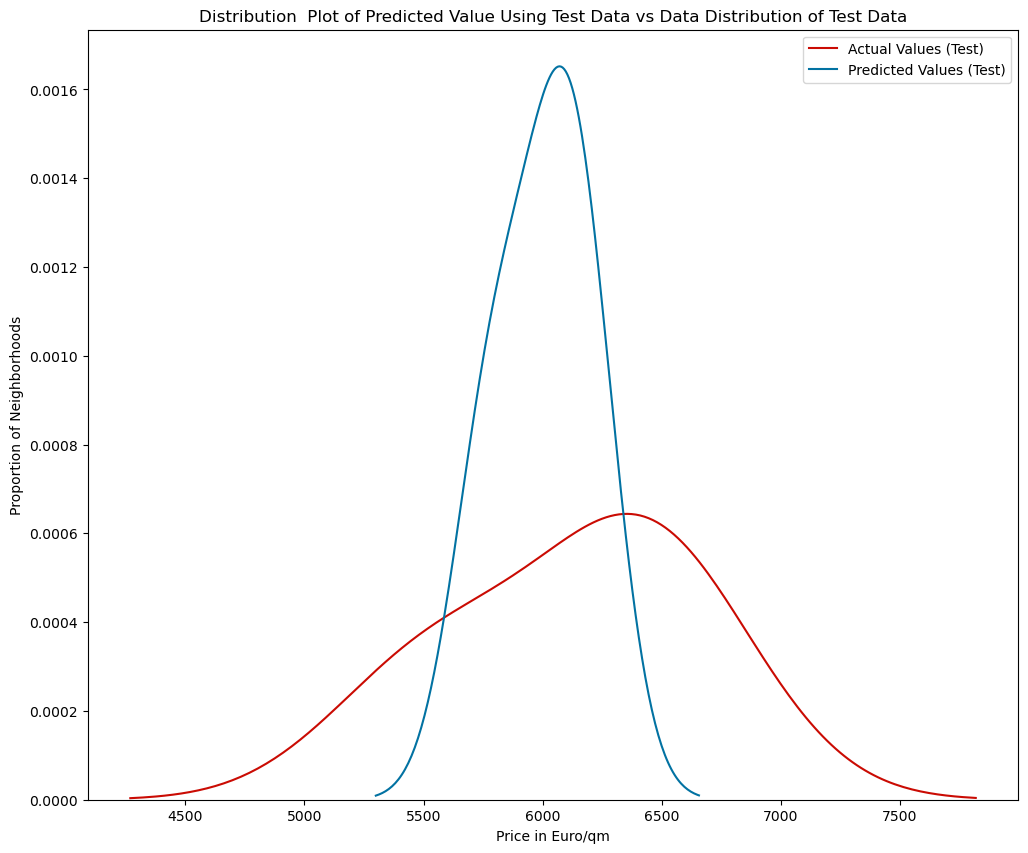

In [530]:
# Plot of SLR

Title='Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_data_new,Yhat_slr_new,"Actual Values (Test)","Predicted Values (Test)",Title)  # good result by poly (order=2, multiple variable polynomial)

## b. MLR

In [531]:
x_new_pr1 = pr1.fit_transform(x_data_new[cols_of_interest])

In [532]:
yhat_MLR_new = poly1.predict(x_new_pr1)
yhat_MLR_new

array([6936.75276502, 6116.41929117, 6357.70389809])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


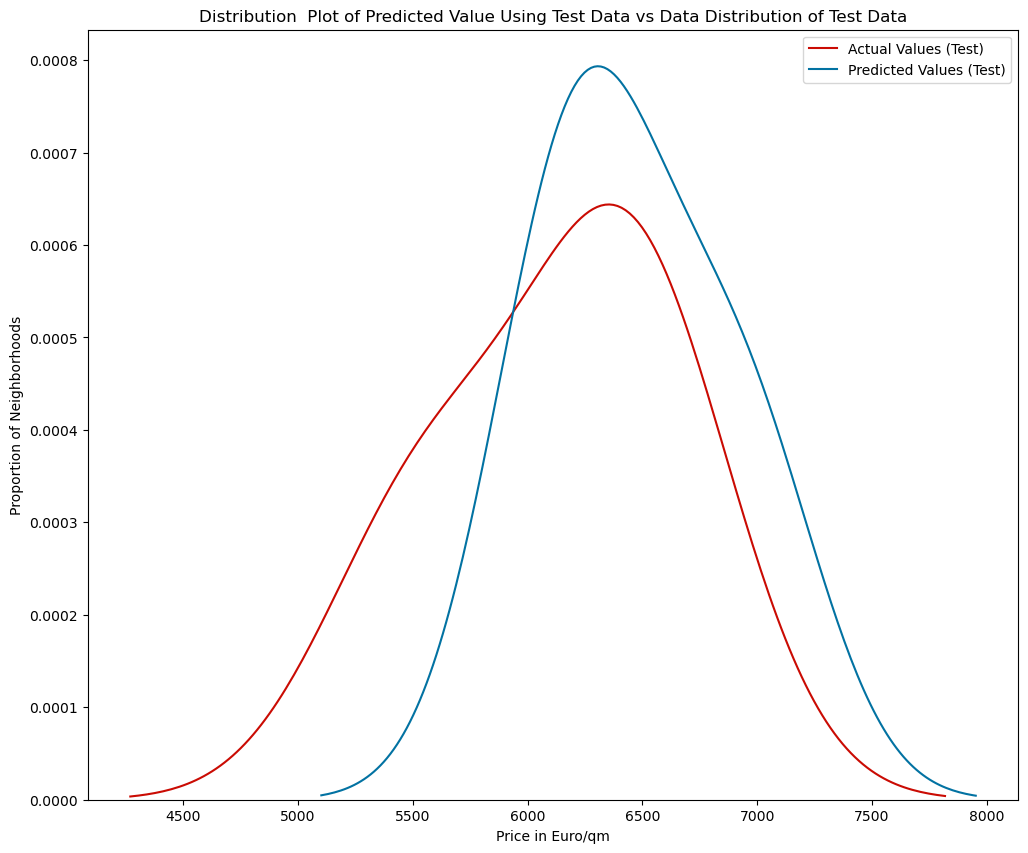

In [533]:
# Plot of MLR

Title='Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_data_new,yhat_MLR_new,"Actual Values (Test)","Predicted Values (Test)",Title)  # good result by poly (order=2, multiple variable polynomial)

## c. MPF

In [534]:
x_new_pr2 = pr2.fit_transform(x_data_new[cols_of_interest])
yhat_new_MPF = poly2.predict(x_new_pr2)
yhat_new_MPF

array([8544.30607028, 5620.69493501, 6907.33810546])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


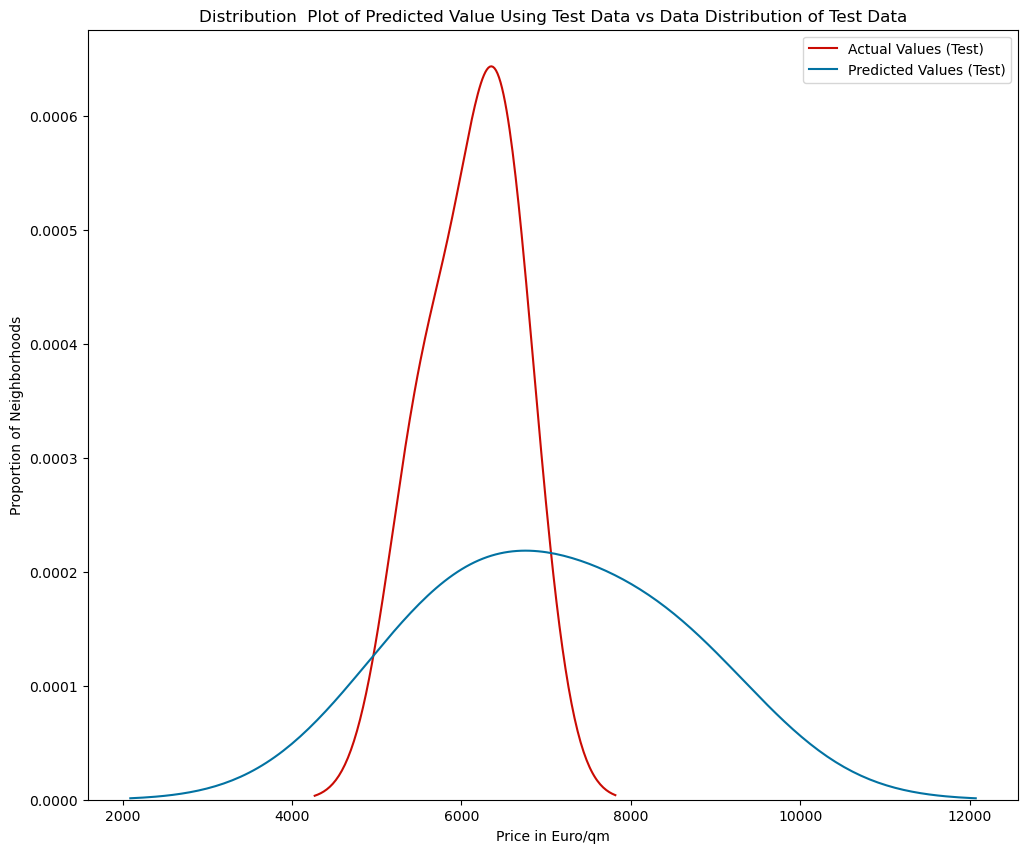

In [535]:
# Plot of MPF

Title='Distribution  Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
DistributionPlot(y_data_new,yhat_new_MPF,"Actual Values (Test)","Predicted Values (Test)",Title)  # good result by poly (order=2, multiple variable polynomial)

# 8. Conclusion

This applied data science project demo summarizes nearly all the tools I have learned from the applied data science specification series. Despite of some drawbacks of venue data provided by Foursquare (e.g. its content is strongly biased to tourists’ interest instead of a full description of neighborhoods), the information can be still processed in a scientific way to make neighborhood clustering and even to develop a successful price prediction model.
The beaty of data science lies in its strength in dealing with common data to reveal its underlying secrets. I am looking forward to all other applications in future with the tools I have learned here. So, keep going!


# Appendex

[1] wiki website of Munich districts: https://de.wikipedia.org/wiki/Stadtbezirke_M%C3%BCnchens

[2] an online source about the Munich housing prices per district: https://suedbayerische-immobilien.de/Immobilienpreise-Muenchen

[3] Geo.json containing geographical data of counties and districts in Germany https://github.com/isellsoap/deutschlandGeoJSON/blob/master/3_regierungsbezirke/1_sehr_hoch.geo.json